In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.datasets import ImageFolder
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
cuda = torch.cuda.is_available()
cuda =False
device = 'cuda' if cuda else 'cpu'
%matplotlib inline

In [2]:
# Overview of ID class names and class identifiers
class_dict = {  "Abyssinian": 0,
                "american_bulldog": 1,
                "american_pit_bull_terrier": 2,
                "basset_hound": 3,
                "beagle": 4,
                "Bengal": 5,
                "Birman": 6,
                "Bombay": 7,
                "boxer": 8,
                "British_Shorthair": 9,
                "chihuahua": 10,
                "Egyptian_Mau": 11,
                "english_cocker_spaniel": 12,
                "english_setter": 13,
                "german_shorthaired": 14,
                "great_pyrenees": 15,
                "havanese": 16,
                "japanese_chin": 17,
                "keeshond": 18,
                "leonberger": 19,
                "Maine_Coon": 20,
                "miniature_pinscher": 21,
                "newfoundland": 22,
                "Persian": 23,
                "pomeranian": 24,
                "pug": 25,
                "Ragdoll": 26,
                "Russian_Blue": 27,
                "saint_bernard": 28,
                "samoyed": 29,
                "scottish_terrier": 30,
                "shiba_inu": 31,
                "Siamese": 32,
                "Sphynx": 33,
                "staffordshire_bull_terrier": 34,
                "wheaten_terrier": 35,
                "yorkshire_terrier": 36}

In [3]:
# Import cats and dogs dataset
all_images_path = ".\cats_and_dogs\images"

# Train/val split with 90/10
import glob
from PIL import Image
from torchvision.transforms import ToTensor
import re

batch_size = 32
img_height = 224
img_width = 224

# Define transformations for ID
train_transform = transforms.Compose([
    transforms.RandomRotation(40),
    transforms.RandomResizedCrop((img_width, img_height)),
    transforms.RandomAffine(degrees=0, translate=(0.2, 0.2), shear=0.2, scale=(0.8, 1.2)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

# Define transformations for OOD
all_transform = transforms.Compose([
    transforms.Resize((img_width, img_height)),
    transforms.ToTensor(),
])

# Custom image dataset to properly load cats and dogs
#  one of the issues was naming the images and assigning them to the correct class in a weird file structure
class CustomImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        img_paths_bad = glob.glob(os.path.join(root_dir, '*.jpg'))  # Cats and dogs only uses .jpg files

        img_paths = [i.replace("\\", "/") for i in img_paths_bad]

        for img_path in img_paths:
            label = os.path.splitext(os.path.basename(img_path))[0]  # Extract label from filename
            self.image_paths.append(img_path)
            self.labels.append(label)

        labs = [class_dict[re.sub(r'_\d+', '', i)] for i in self.labels]
        self.labels = labs

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # When requesting item from the dataset, this returns the correct image, label combination
        #  This is in line with the required pytorch format of a custom dataset https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label


dataset = CustomImageDataset(root_dir="cats_and_dogs/images", transform=all_transform)
n_val = int(0.1 * len(dataset))

# Random 10% of the dataset is validation dataset
train_dataset, val_dataset = random_split(dataset, [len(dataset) - n_val, n_val])
train_dataset.dataset.transform = train_transform

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=False)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=False)


In [4]:
batch_size = 32
img_height = 224
img_width = 224

# Define transformations for ID
train_transform = transforms.Compose([
    transforms.RandomRotation(40),
    transforms.RandomResizedCrop((img_width, img_height)),
    transforms.RandomAffine(degrees=0, translate=(0.2, 0.2), shear=0.2, scale=(0.8, 1.2)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

# Define transformations for OOD
all_transform = transforms.Compose([
    transforms.Resize((img_width, img_height)),
    transforms.ToTensor(),
])

# Imagefolder for ID3
dataset = ImageFolder(root='celebfaces_id3', transform=all_transform)

# Calculate the number of validation samples = 10%
n_val = int(0.1 * len(dataset))

# Split the dataset
train_dataset, val_dataset = random_split(dataset, [len(dataset) - n_val, n_val])
train_dataset.dataset.transform = train_transform

s3_train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=False)
s3_val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=False)

In [7]:
# Load model. Where we transfer learned resnet18 from Imagenet1k weights to cats dogs and Celeb faces
from torchvision.models import resnet18, ResNet18_Weights

pretrained_resnet = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

# Unlock layers to train all the layers instead of just the last few
for param in pretrained_resnet.parameters():
    param.requires_grad = True

# Modify the output layer to 37
num_classes = len(class_dict.items())
pretrained_resnet.fc = nn.Linear(pretrained_resnet.fc.in_features, num_classes)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(pretrained_resnet.parameters(), lr=0.001, momentum=0.9)

#####################
# When using pre-trained weights:
#####################

# Load pre-trained weights
pretrained_resnet.load_state_dict(torch.load('catsDogs_resnet_25.pth'))
pretrained_resnet.eval()

# ---

s3pretrained_resnet = resnet18()

# Unlock layers to train all the layers instead of just the last few
for param in s3pretrained_resnet.parameters():
    param.requires_grad = True

# Modify the output layer to 101, celebfaces classes
s3pretrained_resnet.fc = nn.Linear(s3pretrained_resnet.fc.in_features, 101)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(s3pretrained_resnet.parameters(), lr=0.001, momentum=0.9)

#####################
# When using pre-trained weights:
#####################

# Load pre-trained weights
s3pretrained_resnet.load_state_dict(torch.load('celebFaces_resnet150.pth', map_location=torch.device('cpu')))
s3pretrained_resnet.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [10]:
# Load model. Clean resnet18
new_resnet = resnet18()

# Unlock layers
for param in new_resnet.parameters():
    param.requires_grad = True

# Modify the output layer to 37
num_classes = len(class_dict.items())
new_resnet.fc = nn.Linear(new_resnet.fc.in_features, num_classes)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(new_resnet.parameters(), lr=0.001, momentum=0.9)

#####################
# When using pre-trained weights:
#####################

# Load pre-trained weights
new_resnet.load_state_dict(torch.load('catsDogs_new_resnet_275.pth'))
new_resnet.eval()

# ---

# Load model. Clean resnet18
s3new_resnet = resnet18()

# Unlock layers
for param in s3new_resnet.parameters():
    param.requires_grad = True

# Modify the output layer to 101, celebfaces classes
s3new_resnet.fc = nn.Linear(s3new_resnet.fc.in_features, 101)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(s3new_resnet.parameters(), lr=0.001, momentum=0.9)

#####################
# When using pre-trained weights:
#####################

# Load pre-trained weights
s3new_resnet.load_state_dict(torch.load('celebFaces_new_resnet620.pth', map_location=torch.device('cpu')))
s3new_resnet.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [11]:
# Load OOD datasets for s1,2,3
from torch.utils.data import Subset
from PIL import Image
import glob

preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

s1ood_dataset = ImageFolder(root='imagenet_val', transform=preprocess)
s1OOD_Dataloader = DataLoader(s1ood_dataset, batch_size=32, shuffle=True)
s1nearood_dataset = ImageFolder(root='AnimalnearOOD', transform=preprocess)
s1farood_dataset = ImageFolder(root='imgnetFar', transform=preprocess)
s1nearOOD_Dataloader = DataLoader(s1nearood_dataset, batch_size=32, shuffle=True)
s1farOOD_Dataloader = DataLoader(s1farood_dataset, batch_size=32, shuffle=True)

s2ood_dataset = ImageFolder(root='ood23', transform=preprocess)
s2OOD_Dataloader = DataLoader(s2ood_dataset, batch_size=32, shuffle=True)
s2nearood_dataset = ImageFolder(root='ood23far', transform=preprocess)
s23farood_dataset = ImageFolder(root='ood23near', transform=preprocess)
s2nearOOD_Dataloader = DataLoader(s2nearood_dataset, batch_size=32, shuffle=True)
s23farOOD_Dataloader = DataLoader(s23farood_dataset, batch_size=32, shuffle=True)

s3ood_dataset = ImageFolder(root='ood3', transform=preprocess)
s3OOD_Dataloader = DataLoader(s3ood_dataset, batch_size=32, shuffle=True)
s3nearood_dataset = ImageFolder(root='animalfaces', transform=preprocess)
s3nearOOD_Dataloader = DataLoader(s3nearood_dataset, batch_size=32, shuffle=True)

### OOD detection methods
These methods were taken from different sources. 
Odin, MSP and Energy I got from here https://github.com/deeplearning-wisc/large_scale_ood/blob/master/test_baselines.py

DDU from https://github.com/omegafragger/DDU/blob/main/utils/gmm_utils.py which required a lot of adapting

Mahalanobis I created myself

In [12]:
# Retrieved from https://github.com/deeplearning-wisc/large_scale_ood/blob/master/test_baselines.py

def iterate_data_odin(data_loader, model, epsilon=0.0014, temper=1000):
    criterion = torch.nn.CrossEntropyLoss()
    confs = []
    loader_y = []
    for b, (x, y) in enumerate(data_loader):
        loader_y.append(y)
        x = Variable(x, requires_grad=True)
        outputs = model(x)

        maxIndexTemp = np.argmax(outputs.data.cpu().numpy(), axis=1)
        outputs = outputs / temper

        labels = Variable(torch.LongTensor(maxIndexTemp))
        loss = criterion(outputs, labels)
        loss.backward()

        # Normalizing the gradient to binary in {0, 1}
        gradient = torch.ge(x.grad.data, 0)
        gradient = (gradient.float() - 0.5) * 2

        # Adding small perturbations to images
        tempInputs = torch.add(x.data, gradient, alpha=-epsilon)
        outputs = model(Variable(tempInputs))
        outputs = outputs / temper
        # Calculating the confidence after adding perturbations
        nnOutputs = outputs.data.cpu()
        nnOutputs = nnOutputs.numpy()
        nnOutputs = nnOutputs - np.max(nnOutputs, axis=1, keepdims=True)
        nnOutputs = np.exp(nnOutputs) / np.sum(np.exp(nnOutputs), axis=1, keepdims=True)

        confs.extend(np.max(nnOutputs, axis=1))

    return np.array(confs), loader_y

# s12_tl_odin_in_scores, s12_tl_odin_in_y = iterate_data_odin(train_loader, pretrained_resnet)
# s1_tl_odin_out_scores, s1_tl_odin_out_y = iterate_data_odin(s1OOD_Dataloader, pretrained_resnet)
# s2_tl_odin_out_scores, s2_tl_odin_out_y = iterate_data_odin(s2OOD_Dataloader, pretrained_resnet)

# s12_new_odin_in_scores, s12_new_odin_in_y = iterate_data_odin(train_loader, new_resnet)
# s1_new_odin_out_scores, s1_new_odin_out_y = iterate_data_odin(s1OOD_Dataloader, new_resnet)
# s2_new_odin_out_scores, s2_new_odin_out_y = iterate_data_odin(s2OOD_Dataloader, new_resnet)

# odin_s12_tl_in_examples = s12_tl_odin_in_scores.reshape((-1, 1))
# odin_s1_tl_out_examples = s1_tl_odin_out_scores.reshape((-1, 1))
# odin_s2_tl_out_examples = s2_tl_odin_out_scores.reshape((-1, 1))
# odin_s12_new_in_examples = s12_new_odin_in_scores.reshape((-1, 1))
# odin_s1_new_out_examples = s1_new_odin_out_scores.reshape((-1, 1))
# odin_s2_new_out_examples = s2_new_odin_out_scores.reshape((-1, 1))

s3_tl_odin_in_scores, s3_tl_odin_in_y = iterate_data_odin(s3_train_loader, s3pretrained_resnet)
s3_tl_odin_out_scores, s3_tl_odin_out_y = iterate_data_odin(s3OOD_Dataloader, s3pretrained_resnet)
s3_new_odin_in_scores, s3_new_odin_in_y = iterate_data_odin(s3_train_loader, s3new_resnet)
s3_new_odin_out_scores, s3_new_odin_out_y = iterate_data_odin(s3OOD_Dataloader, s3new_resnet)
odin_s3_tl_in_examples = s3_tl_odin_in_scores.reshape((-1, 1))
odin_s3_tl_out_examples = s3_tl_odin_out_scores.reshape((-1, 1))
odin_s3_new_in_examples = s3_new_odin_in_scores.reshape((-1, 1))
odin_s3_new_out_examples = s3_new_odin_out_scores.reshape((-1, 1))

flat_s3_tl_odin_in_y = [value.item() for tensor in s3_tl_odin_in_y for value in tensor]
flat_s3_new_odin_in_y = [value.item() for tensor in s3_new_odin_in_y for value in tensor]
flat_s3_tl_odin_out_y = [value.item() for tensor in s3_tl_odin_out_y for value in tensor]
flat_s3_new_odin_out_y = [value.item() for tensor in s3_new_odin_out_y for value in tensor]

np.save('exp1savesGOODEPOCHS/flat_s3_tl_odin_in_y.npy', flat_s3_tl_odin_in_y)
np.save('exp1savesGOODEPOCHS/flat_s3_new_odin_in_y .npy', flat_s3_new_odin_in_y)
np.save('exp1savesGOODEPOCHS/flat_s3_tl_odin_out_y.npy', flat_s3_tl_odin_out_y)
np.save('exp1savesGOODEPOCHS/flat_s3_new_odin_out_y.npy', flat_s3_new_odin_out_y)

# flat_s3_tl_odin_in_y = np.load('exp1savesGOODEPOCHS/flat_s3_tl_odin_in_y.npy')
# flat_s3_new_odin_in_y = np.load('exp1savesGOODEPOCHS/flat_s3_new_odin_in_y.npy')
# flat_s3_tl_odin_out_y = np.load('exp1savesGOODEPOCHS/flat_s3_tl_odin_out_y.npy')
# flat_s3_new_odin_out_y = np.load('exp1savesGOODEPOCHS/flat_s3_new_odin_out_y.npy')

In [13]:
# np.save('exp1savesGOODEPOCHS/odin_s12_tl_in_examples.npy', odin_s12_tl_in_examples)
# np.save('exp1savesGOODEPOCHS/odin_s1_tl_out_examples.npy', odin_s1_tl_out_examples)
# np.save('exp1savesGOODEPOCHS/odin_s2_tl_out_examples.npy', odin_s2_tl_out_examples)
# np.save('exp1savesGOODEPOCHS/odin_s12_new_in_examples.npy', odin_s12_new_in_examples)
# np.save('exp1savesGOODEPOCHS/odin_s1_new_out_examples.npy', odin_s1_new_out_examples)
# np.save('exp1savesGOODEPOCHS/odin_s2_new_out_examples.npy', odin_s2_new_out_examples)

odin_s12_tl_in_examples = np.load('exp1savesGOODEPOCHS/odin_s12_tl_in_examples.npy')
odin_s1_tl_out_examples = np.load('exp1savesGOODEPOCHS/odin_s1_tl_out_examples.npy')
odin_s2_tl_out_examples = np.load('exp1savesGOODEPOCHS/odin_s2_tl_out_examples.npy')
odin_s12_new_in_examples = np.load('exp1savesGOODEPOCHS/odin_s12_new_in_examples.npy')
odin_s1_new_out_examples = np.load('exp1savesGOODEPOCHS/odin_s1_new_out_examples.npy')
odin_s2_new_out_examples = np.load('exp1savesGOODEPOCHS/odin_s2_new_out_examples.npy')

np.save('exp1savesGOODEPOCHS/odin_s3_tl_in_examples.npy', odin_s3_tl_in_examples)
np.save('exp1savesGOODEPOCHS/odin_s3_tl_out_examples.npy', odin_s3_tl_out_examples)
np.save('exp1savesGOODEPOCHS/odin_s3_new_in_examples.npy', odin_s3_new_in_examples)
np.save('exp1savesGOODEPOCHS/odin_s3_new_out_examples.npy', odin_s3_new_out_examples)

# odin_s3_tl_in_examples = np.load('exp1savesGOODEPOCHS/odin_s3_tl_in_examples.npy')
# odin_s3_tl_out_examples = np.load('exp1savesGOODEPOCHS/odin_s3_tl_out_examples.npy')
# odin_s3_new_in_examples = np.load('exp1savesGOODEPOCHS/odin_s3_new_in_examples.npy')
# odin_s3_new_out_examples = np.load('exp1savesGOODEPOCHS/odin_s3_new_out_examples.npy')

In [14]:
def iterate_data_energy(data_loader, model, temper=1):
    confs = []
    loader_y = []
    for b, (x, y) in enumerate(data_loader):
        loader_y.append(y)
        with torch.no_grad():
            x = x
            # compute output, measure accuracy and record loss.
            logits = model(x)

            conf = temper * torch.logsumexp(logits / temper, dim=1)
            confs.extend(conf.data.cpu().numpy())
    return np.array(confs), loader_y

# s12_tl_energy_in_scores, s12_tl_energy_in_y = iterate_data_energy(train_loader, pretrained_resnet)
# s1_tl_energy_out_scores, s1_tl_energy_out_y = iterate_data_energy(s1OOD_Dataloader, pretrained_resnet)
# s2_tl_energy_out_scores, s2_tl_energy_out_y = iterate_data_energy(s2OOD_Dataloader, pretrained_resnet)

# s12_new_energy_in_scores, s12_new_energy_in_y = iterate_data_energy(train_loader, new_resnet)
# s1_new_energy_out_scores, s1_new_energy_out_y = iterate_data_energy(s1OOD_Dataloader, new_resnet)
# s2_new_energy_out_scores, s2_new_energy_out_y = iterate_data_energy(s2OOD_Dataloader, new_resnet)

# energy_s12_tl_in_examples = s12_tl_energy_in_scores.reshape((-1, 1))
# energy_s1_tl_out_examples = s1_tl_energy_out_scores.reshape((-1, 1))
# energy_s2_tl_out_examples = s2_tl_energy_out_scores.reshape((-1, 1))
# energy_s12_new_in_examples = s12_new_energy_in_scores.reshape((-1, 1))
# energy_s1_new_out_examples = s1_new_energy_out_scores.reshape((-1, 1))
# energy_s2_new_out_examples = s2_new_energy_out_scores.reshape((-1, 1))

s3_tl_energy_in_scores, s3_tl_energy_in_y = iterate_data_energy(s3_train_loader, s3pretrained_resnet)
s3_tl_energy_out_scores, s3_tl_energy_out_y = iterate_data_energy(s3OOD_Dataloader, s3pretrained_resnet)
s3_new_energy_in_scores, s3_new_energy_in_y = iterate_data_energy(s3_train_loader, s3new_resnet)
s3_new_energy_out_scores, s3_new_energy_out_y = iterate_data_energy(s3OOD_Dataloader, s3new_resnet)
energy_s3_tl_in_examples = s3_tl_energy_in_scores.reshape((-1, 1))
energy_s3_tl_out_examples = s3_tl_energy_out_scores.reshape((-1, 1))
energy_s3_new_in_examples = s3_new_energy_in_scores.reshape((-1, 1))
energy_s3_new_out_examples = s3_new_energy_out_scores.reshape((-1, 1))

flat_s3_tl_energy_in_y = [value.item() for tensor in s3_tl_energy_in_y for value in tensor]
flat_s3_new_energy_in_y = [value.item() for tensor in s3_new_energy_in_y for value in tensor]
flat_s3_tl_energy_out_y = [value.item() for tensor in s3_tl_energy_out_y for value in tensor]
flat_s3_new_energy_out_y = [value.item() for tensor in s3_new_energy_out_y for value in tensor]

np.save('exp1savesGOODEPOCHS/flat_s3_tl_energy_in_y.npy', flat_s3_tl_energy_in_y)
np.save('exp1savesGOODEPOCHS/flat_s3_new_energy_in_y .npy', flat_s3_new_energy_in_y)
np.save('exp1savesGOODEPOCHS/flat_s3_tl_energy_out_y.npy', flat_s3_tl_energy_out_y)
np.save('exp1savesGOODEPOCHS/flat_s3_new_energy_out_y.npy', flat_s3_new_energy_out_y)

# flat_s3_tl_energy_in_y = np.load('exp1savesGOODEPOCHS/flat_s3_tl_energy_in_y.npy')
# flat_s3_new_energy_in_y = np.load('exp1savesGOODEPOCHS/flat_s3_new_energy_in_y.npy')
# flat_s3_tl_energy_out_y = np.load('exp1savesGOODEPOCHS/flat_s3_tl_energy_out_y.npy')
# flat_s3_new_energy_out_y = np.load('exp1savesGOODEPOCHS/flat_s3_new_energy_out_y.npy')


In [15]:
# np.save('exp1savesGOODEPOCHS/energy_s12_tl_in_examples.npy', energy_s12_tl_in_examples)
# np.save('exp1savesGOODEPOCHS/energy_s1_tl_out_examples.npy', energy_s1_tl_out_examples)
# np.save('exp1savesGOODEPOCHS/energy_s2_tl_out_examples.npy', energy_s2_tl_out_examples)
# np.save('exp1savesGOODEPOCHS/energy_s12_new_in_examples.npy', energy_s12_new_in_examples)
# np.save('exp1savesGOODEPOCHS/energy_s1_new_out_examples.npy', energy_s1_new_out_examples)
# np.save('exp1savesGOODEPOCHS/energy_s2_new_out_examples.npy', energy_s2_new_out_examples)

energy_s12_tl_in_examples = np.load('exp1savesGOODEPOCHS/energy_s12_tl_in_examples.npy')
energy_s1_tl_out_examples = np.load('exp1savesGOODEPOCHS/energy_s1_tl_out_examples.npy')
energy_s2_tl_out_examples = np.load('exp1savesGOODEPOCHS/energy_s2_tl_out_examples.npy')
energy_s12_new_in_examples = np.load('exp1savesGOODEPOCHS/energy_s12_new_in_examples.npy')
energy_s1_new_out_examples = np.load('exp1savesGOODEPOCHS/energy_s1_new_out_examples.npy')
energy_s2_new_out_examples = np.load('exp1savesGOODEPOCHS/energy_s2_new_out_examples.npy')

np.save('exp1savesGOODEPOCHS/energy_s3_tl_in_examples.npy', energy_s3_tl_in_examples)
np.save('exp1savesGOODEPOCHS/energy_s3_tl_out_examples.npy', energy_s3_tl_out_examples)
np.save('exp1savesGOODEPOCHS/energy_s3_new_in_examples.npy', energy_s3_new_in_examples)
np.save('exp1savesGOODEPOCHS/energy_s3_new_out_examples.npy', energy_s3_new_out_examples)
# energy_s3_tl_in_examples = np.load('exp1savesGOODEPOCHS/energy_s3_tl_in_examples.npy')
# energy_s3_tl_out_examples = np.load('exp1savesGOODEPOCHS/energy_s3_tl_out_examples.npy')
# energy_s3_new_in_examples = np.load('exp1savesGOODEPOCHS/energy_s3_new_in_examples.npy')
# energy_s3_new_out_examples = np.load('exp1savesGOODEPOCHS/energy_s3_new_out_examples.npy')

In [16]:
def iterate_data_msp(data_loader, model):
    confs = []
    m = torch.nn.Softmax(dim=-1).cuda()
    loader_y = []
    for b, (x, y) in enumerate(data_loader):
        loader_y.append(y)
        with torch.no_grad():
            x = x
            # compute output, measure accuracy and record loss.
            logits = model(x)

            conf, _ = torch.max(m(logits), dim=-1)
            confs.extend(conf.data.cpu().numpy())
    return np.array(confs), loader_y

# s12_tl_msp_in_scores, s12_tl_msp_in_y = iterate_data_msp(train_loader, pretrained_resnet)
# s1_tl_msp_out_scores, s1_tl_msp_out_y = iterate_data_msp(s1OOD_Dataloader, pretrained_resnet)
# s2_tl_msp_out_scores, s2_tl_msp_out_y = iterate_data_msp(s2OOD_Dataloader, pretrained_resnet)

# s12_new_msp_in_scores, s12_new_msp_in_y = iterate_data_msp(train_loader, new_resnet)
# s1_new_msp_out_scores, s1_new_msp_out_y = iterate_data_msp(s1OOD_Dataloader, new_resnet)
# s2_new_msp_out_scores, s2_new_msp_out_y = iterate_data_msp(s2OOD_Dataloader, new_resnet)

# msp_s12_tl_in_examples = s12_tl_msp_in_scores.reshape((-1, 1))
# msp_s1_tl_out_examples = s1_tl_msp_out_scores.reshape((-1, 1))
# msp_s2_tl_out_examples = s2_tl_msp_out_scores.reshape((-1, 1))
# msp_s12_new_in_examples = s12_new_msp_in_scores.reshape((-1, 1))
# msp_s1_new_out_examples = s1_new_msp_out_scores.reshape((-1, 1))
# msp_s2_new_out_examples = s2_new_msp_out_scores.reshape((-1, 1))

s3_tl_msp_in_scores, s3_tl_msp_in_y = iterate_data_msp(s3_train_loader, s3pretrained_resnet)
s3_tl_msp_out_scores, s3_tl_msp_out_y = iterate_data_msp(s3OOD_Dataloader, s3pretrained_resnet)
s3_new_msp_in_scores, s3_new_msp_in_y = iterate_data_msp(s3_train_loader, s3new_resnet)
s3_new_msp_out_scores, s3_new_msp_out_y = iterate_data_msp(s3OOD_Dataloader, s3new_resnet)
msp_s3_tl_in_examples = s3_tl_msp_in_scores.reshape((-1, 1))
msp_s3_tl_out_examples = s3_tl_msp_out_scores.reshape((-1, 1))
msp_s3_new_in_examples = s3_new_msp_in_scores.reshape((-1, 1))
msp_s3_new_out_examples = s3_new_msp_out_scores.reshape((-1, 1))

flat_s3_tl_msp_in_y = [value.item() for tensor in s3_tl_msp_in_y for value in tensor]
flat_s3_new_msp_in_y = [value.item() for tensor in s3_new_msp_in_y for value in tensor]
flat_s3_tl_msp_out_y = [value.item() for tensor in s3_tl_msp_out_y for value in tensor]
flat_s3_new_msp_out_y = [value.item() for tensor in s3_new_msp_out_y for value in tensor]

np.save('exp1savesGOODEPOCHS/flat_s3_tl_msp_in_y.npy', flat_s3_tl_msp_in_y)
np.save('exp1savesGOODEPOCHS/flat_s3_new_msp_in_y .npy', flat_s3_new_msp_in_y)
np.save('exp1savesGOODEPOCHS/flat_s3_tl_msp_out_y.npy', flat_s3_tl_msp_out_y)
np.save('exp1savesGOODEPOCHS/flat_s3_new_msp_out_y.npy', flat_s3_new_msp_out_y)

# flat_s3_tl_msp_in_y = np.load('exp1savesGOODEPOCHS/flat_s3_tl_msp_in_y.npy')
# flat_s3_new_msp_in_y = np.load('exp1savesGOODEPOCHS/flat_s3_new_msp_in_y.npy')
# flat_s3_tl_msp_out_y = np.load('exp1savesGOODEPOCHS/flat_s3_tl_msp_out_y.npy')
# flat_s3_new_msp_out_y = np.load('exp1savesGOODEPOCHS/flat_s3_new_msp_out_y.npy')


In [17]:
# np.save('exp1savesGOODEPOCHS/msp_s12_tl_in_examples.npy', msp_s12_tl_in_examples)
# np.save('exp1savesGOODEPOCHS/msp_s1_tl_out_examples.npy', msp_s1_tl_out_examples)
# np.save('exp1savesGOODEPOCHS/msp_s2_tl_out_examples.npy', msp_s2_tl_out_examples)
# np.save('exp1savesGOODEPOCHS/msp_s12_new_in_examples.npy', msp_s12_new_in_examples)
# np.save('exp1savesGOODEPOCHS/msp_s1_new_out_examples.npy', msp_s1_new_out_examples)
# np.save('exp1savesGOODEPOCHS/msp_s2_new_out_examples.npy', msp_s2_new_out_examples)

msp_s12_tl_in_examples = np.load('exp1savesGOODEPOCHS/msp_s12_tl_in_examples.npy')
msp_s1_tl_out_examples = np.load('exp1savesGOODEPOCHS/msp_s1_tl_out_examples.npy')
msp_s2_tl_out_examples = np.load('exp1savesGOODEPOCHS/msp_s2_tl_out_examples.npy')
msp_s12_new_in_examples = np.load('exp1savesGOODEPOCHS/msp_s12_new_in_examples.npy')
msp_s1_new_out_examples = np.load('exp1savesGOODEPOCHS/msp_s1_new_out_examples.npy')
msp_s2_new_out_examples = np.load('exp1savesGOODEPOCHS/msp_s2_new_out_examples.npy')

np.save('exp1savesGOODEPOCHS/msp_s3_tl_in_examples.npy', msp_s3_tl_in_examples)
np.save('exp1savesGOODEPOCHS/msp_s3_tl_out_examples.npy', msp_s3_tl_out_examples)
np.save('exp1savesGOODEPOCHS/msp_s3_new_in_examples.npy', msp_s3_new_in_examples)
np.save('exp1savesGOODEPOCHS/msp_s3_new_out_examples.npy', msp_s3_new_out_examples)
# msp_s3_tl_in_examples = np.load('exp1savesGOODEPOCHS/msp_s3_tl_in_examples.npy')
# msp_s3_tl_out_examples = np.load('exp1savesGOODEPOCHS/msp_s3_tl_out_examples.npy')
# msp_s3_new_in_examples = np.load('exp1savesGOODEPOCHS/msp_s3_new_in_examples.npy')
# msp_s3_new_out_examples = np.load('exp1savesGOODEPOCHS/msp_s3_new_out_examples.npy')

In [18]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

def get_logits_labels(model, data_loader, device):
    """
    Utility function to get logits and labels.
    """
    model.eval()
    logits = []
    labels = []
    with torch.no_grad():
        for data, label in data_loader:
            data = data.to(device)
            label = label.to(device)

            logit = model(data)
            logits.append(logit)
            labels.append(label)
    logits = torch.cat(logits, dim=0)
    labels = torch.cat(labels, dim=0)
    return logits, labels

def test_classification_net(model, data_loader, device):
    """
    This function reports classification accuracy and confusion matrix over a dataset.
    """
    logits, labels = get_logits_labels(model, data_loader, device)
    softmax_prob = F.softmax(logits, dim=1)

    """
    This function reports classification accuracy and confusion matrix given softmax vectors and
    labels from a model.
    """
    labels_list = []
    predictions_list = []
    confidence_vals_list = []

    confidence_vals, predictions = torch.max(softmax_prob, dim=1)
    labels_list.extend(labels.cpu().numpy())
    predictions_list.extend(predictions.cpu().numpy())
    confidence_vals_list.extend(confidence_vals.cpu().numpy())
    accuracy = accuracy_score(labels_list, predictions_list)
    return (
        confusion_matrix(labels_list, predictions_list),
        accuracy,
        labels_list,
        predictions_list,
        confidence_vals_list,
    )

In [19]:
from calibration_metrics import expected_calibration_error
from temperature_scaling import ModelWithTemperature
from gmm_utils import get_embeddings, gmm_fit, gmm_evaluate
from ood_metrics import get_roc_auc, get_roc_auc_logits
from uncertainty_confidence import entropy, logsumexp
import math


def iterate_data_ddu(train_loader, val_loader, out_loader, model, num_classes=37):
    # Evaluating the models
    accuracies = []
    
    # Pre temperature scaling
    # m1 - Uncertainty/Confidence Metric 1
    #      for deterministic model: logsumexp, for ensemble: entropy
    # m2 - Uncertainty/Confidence Metric 2
    #      for deterministic model: entropy, for ensemble: MI
    eces = []
    m1_aurocs = []
    m1_auprcs = []
    m2_aurocs = []
    m2_auprcs = []
    
    # Post temperature scaling
    t_eces = []
    t_m1_aurocs = []
    t_m1_auprcs = []
    t_m2_aurocs = []
    t_m2_auprcs = []
    
    for i in range(1):
        print(f"Evaluating run: {(i+1)}")
        device = "cpu"
        model_type = "gmm"
    
        # Evaluating the model(s)
        (conf_matrix, accuracy, labels_list, predictions, confidences,) = test_classification_net(
            model, train_loader, device)
        ece = expected_calibration_error(confidences, predictions, labels_list, num_bins=15)
    
        temp_scaled_net = ModelWithTemperature(model)
        temp_scaled_net.set_temperature(train_loader)
        topt = temp_scaled_net.temperature
    
        (t_conf_matrix, t_accuracy, t_labels_list, t_predictions, t_confidences,) = test_classification_net(
            temp_scaled_net, train_loader, device)
        t_ece = expected_calibration_error(t_confidences, t_predictions, t_labels_list, num_bins=15)
    
        if (model_type == "gmm"):
            # Evaluate a GMM model
            print("GMM Model")
            embeddings, labels = get_embeddings(model, train_loader, num_dim=num_classes, dtype=torch.double,
                                                device=device, storage_device=device,)
    
            try:
                gaussians_model, jitter_eps = gmm_fit(embeddings=embeddings, labels=labels, num_classes=num_classes)
                logits, labels = gmm_evaluate(model, gaussians_model, train_loader, device=device, 
                                              num_classes=num_classes, storage_device=device,)
    
                val_logits, val_labels = gmm_evaluate(model, gaussians_model, val_loader, device=device, 
                                                      num_classes=num_classes, storage_device=device,)
    
                ood_logits, ood_labels = gmm_evaluate(model, gaussians_model, out_loader, device=device, 
                                                      num_classes=num_classes, storage_device=device,)
    
                (m1_fpr, m1_tpr, m1_thresholds), (m1_precision, m1_recall, m1_prc_thresholds), m1_auroc, m1_auprc = get_roc_auc_logits(logits, ood_logits, logsumexp, device, confidence=True)
                (m2_fpr, m2_tpr, m2_thresholds), (m2_precision, m2_recall, m2_prc_thresholds), m2_auroc, m2_auprc = get_roc_auc_logits(logits, ood_logits, entropy, device)
    
                t_m1_auroc = m1_auroc
                t_m1_auprc = m1_auprc
                t_m2_auroc = m2_auroc
                t_m2_auprc = m2_auprc
    
            except RuntimeError as e:
                print("Runtime Error caught: " + str(e))
                continue
    
        else:
            # Evaluate a normal Softmax model
            print("Softmax Model")
            (_, _, _), (_, _, _), m1_auroc, m1_auprc = get_roc_auc(model, train_loader, out_loader, logsumexp, 
                                                                   device, confidence=True)
            (_, _, _), (_, _, _), m2_auroc, m2_auprc = get_roc_auc(model, train_loader, out_loader, entropy, device)
    
            (_, _, _), (_, _, _), t_m1_auroc, t_m1_auprc = get_roc_auc(temp_scaled_net, train_loader, out_loader, 
                                                                       logsumexp, device, confidence=True,)
            (_, _, _), (_, _, _), t_m2_auroc, t_m2_auprc = get_roc_auc(temp_scaled_net, train_loader, out_loader, 
                                                                       entropy, device)
    
        accuracies.append(accuracy)
    
        # Pre-temperature results
        eces.append(ece)
        m1_aurocs.append(m1_auroc)
        m1_auprcs.append(m1_auprc)
        m2_aurocs.append(m2_auroc)
        m2_auprcs.append(m2_auprc)
    
        # Post-temperature results
        t_eces.append(t_ece)
        t_m1_aurocs.append(t_m1_auroc)
        t_m1_auprcs.append(t_m1_auprc)
        t_m2_aurocs.append(t_m2_auroc)
        t_m2_auprcs.append(t_m2_auprc)
    
    accuracy_tensor = torch.tensor(accuracies)
    ece_tensor = torch.tensor(eces)
    m1_auroc_tensor = torch.tensor(m1_aurocs)
    m1_auprc_tensor = torch.tensor(m1_auprcs)
    m2_auroc_tensor = torch.tensor(m2_aurocs)
    m2_auprc_tensor = torch.tensor(m2_auprcs)
    
    t_ece_tensor = torch.tensor(t_eces)
    t_m1_auroc_tensor = torch.tensor(t_m1_aurocs)
    t_m1_auprc_tensor = torch.tensor(t_m1_auprcs)
    t_m2_auroc_tensor = torch.tensor(t_m2_aurocs)
    t_m2_auprc_tensor = torch.tensor(t_m2_auprcs)
    
    mean_accuracy = torch.mean(accuracy_tensor)
    mean_ece = torch.mean(ece_tensor)
    mean_m1_auroc = torch.mean(m1_auroc_tensor)
    mean_m1_auprc = torch.mean(m1_auprc_tensor)
    mean_m2_auroc = torch.mean(m2_auroc_tensor)
    mean_m2_auprc = torch.mean(m2_auprc_tensor)
    
    mean_t_ece = torch.mean(t_ece_tensor)
    mean_t_m1_auroc = torch.mean(t_m1_auroc_tensor)
    mean_t_m1_auprc = torch.mean(t_m1_auprc_tensor)
    mean_t_m2_auroc = torch.mean(t_m2_auroc_tensor)
    mean_t_m2_auprc = torch.mean(t_m2_auprc_tensor)
    
    std_accuracy = torch.std(accuracy_tensor) / math.sqrt(accuracy_tensor.shape[0])
    std_ece = torch.std(ece_tensor) / math.sqrt(ece_tensor.shape[0])
    std_m1_auroc = torch.std(m1_auroc_tensor) / math.sqrt(m1_auroc_tensor.shape[0])
    std_m1_auprc = torch.std(m1_auprc_tensor) / math.sqrt(m1_auprc_tensor.shape[0])
    std_m2_auroc = torch.std(m2_auroc_tensor) / math.sqrt(m2_auroc_tensor.shape[0])
    std_m2_auprc = torch.std(m2_auprc_tensor) / math.sqrt(m2_auprc_tensor.shape[0])
    
    std_t_ece = torch.std(t_ece_tensor) / math.sqrt(t_ece_tensor.shape[0])
    std_t_m1_auroc = torch.std(t_m1_auroc_tensor) / math.sqrt(t_m1_auroc_tensor.shape[0])
    std_t_m1_auprc = torch.std(t_m1_auprc_tensor) / math.sqrt(t_m1_auprc_tensor.shape[0])
    std_t_m2_auroc = torch.std(t_m2_auroc_tensor) / math.sqrt(t_m2_auroc_tensor.shape[0])
    std_t_m2_auprc = torch.std(t_m2_auprc_tensor) / math.sqrt(t_m2_auprc_tensor.shape[0])
    
    res_dict = {}
    res_dict["mean"] = {}
    res_dict["mean"]["accuracy"] = mean_accuracy.item()
    res_dict["mean"]["ece"] = mean_ece.item()
    res_dict["mean"]["m1_auroc"] = mean_m1_auroc.item()
    res_dict["mean"]["m1_auprc"] = mean_m1_auprc.item()
    res_dict["mean"]["m2_auroc"] = mean_m2_auroc.item()
    res_dict["mean"]["m2_auprc"] = mean_m2_auprc.item()
    res_dict["mean"]["t_ece"] = mean_t_ece.item()
    res_dict["mean"]["t_m1_auroc"] = mean_t_m1_auroc.item()
    res_dict["mean"]["t_m1_auprc"] = mean_t_m1_auprc.item()
    res_dict["mean"]["t_m2_auroc"] = mean_t_m2_auroc.item()
    res_dict["mean"]["t_m2_auprc"] = mean_t_m2_auprc.item()
    
    res_dict["std"] = {}
    res_dict["std"]["accuracy"] = std_accuracy.item()
    res_dict["std"]["ece"] = std_ece.item()
    res_dict["std"]["m1_auroc"] = std_m1_auroc.item()
    res_dict["std"]["m1_auprc"] = std_m1_auprc.item()
    res_dict["std"]["m2_auroc"] = std_m2_auroc.item()
    res_dict["std"]["m2_auprc"] = std_m2_auprc.item()
    res_dict["std"]["t_ece"] = std_t_ece.item()
    res_dict["std"]["t_m1_auroc"] = std_t_m1_auroc.item()
    res_dict["std"]["t_m1_auprc"] = std_t_m1_auprc.item()
    res_dict["std"]["t_m2_auroc"] = std_t_m2_auroc.item()
    res_dict["std"]["t_m2_auprc"] = std_t_m2_auprc.item()
    
    res_dict["mean"] = {}
    res_dict["mean"]["accuracy"] = mean_accuracy.item()
    res_dict["mean"]["ece"] = mean_ece.item()
    res_dict["mean"]["m1_auroc"] = mean_m1_auroc.item()
    res_dict["mean"]["m1_auprc"] = mean_m1_auprc.item()
    res_dict["mean"]["m2_auroc"] = mean_m2_auroc.item()
    res_dict["mean"]["m2_auprc"] = mean_m2_auprc.item()
    res_dict["mean"]["t_ece"] = mean_t_ece.item()
    res_dict["mean"]["t_m1_auroc"] = mean_t_m1_auroc.item()
    res_dict["mean"]["t_m1_auprc"] = mean_t_m1_auprc.item()
    res_dict["mean"]["t_m2_auroc"] = mean_t_m2_auroc.item()
    res_dict["mean"]["t_m2_auprc"] = mean_t_m2_auprc.item()
    
    res_dict["values"] = {}
    res_dict["values"]["accuracy"] = accuracies
    res_dict["values"]["ece"] = eces
    res_dict["values"]["m1_auroc"] = m1_aurocs
    res_dict["values"]["m1_auprc"] = m1_auprcs
    res_dict["values"]["m2_auroc"] = m2_aurocs
    res_dict["values"]["m2_auprc"] = m2_auprcs
    res_dict["values"]["t_ece"] = t_eces
    res_dict["values"]["t_m1_auroc"] = t_m1_aurocs
    res_dict["values"]["t_m1_auprc"] = t_m1_auprcs
    res_dict["values"]["t_m2_auroc"] = t_m2_aurocs
    res_dict["values"]["t_m2_auprc"] = t_m2_auprcs
    
    ddu_in_examples = torch.amax(logits, dim=-1).numpy()
    ddu_out_examples = torch.amax(ood_logits, dim=-1).numpy()

    ddu_in_y = labels
    ddu_out_y = ood_labels

    return ddu_in_examples, ddu_out_examples, ddu_in_y, ddu_out_y

# s12_tl_ddu_in_scores, s1_tl_ddu_out_scores, s12_tl_ddu_in_y, s1_tl_ddu_out_y = iterate_data_ddu(train_loader, val_loader, s1OOD_Dataloader, pretrained_resnet)
# s12_tl_ddu_in_scores, s2_tl_ddu_out_scores, s12_tl_ddu_in_y, s2_tl_ddu_out_y = iterate_data_ddu(train_loader, val_loader, s2OOD_Dataloader, pretrained_resnet)
# s12_new_ddu_in_scores, s1_new_ddu_out_scores, s12_new_ddu_in_y, s1_new_ddu_out_y = iterate_data_ddu(train_loader, val_loader, s1OOD_Dataloader, new_resnet)
# s12_new_ddu_in_scores, s2_new_ddu_out_scores, s12_new_ddu_in_y, s2_new_ddu_out_y = iterate_data_ddu(train_loader, val_loader, s2OOD_Dataloader, new_resnet)

s3_tl_ddu_in_scores, s3_tl_ddu_out_scores, s3_tl_ddu_in_y, s3_tl_ddu_out_y = iterate_data_ddu(s3_train_loader, s3_val_loader, s3OOD_Dataloader, s3pretrained_resnet, num_classes=101)
s3_new_ddu_in_scores, s3_new_ddu_out_scores, s3_new_ddu_in_y, s3_new_ddu_out_y = iterate_data_ddu(s3_train_loader, s3_val_loader, s3OOD_Dataloader, s3new_resnet, num_classes=101)


Evaluating run: 1
Before temperature - NLL: 0.316, ECE: 0.030
Optimal temperature: 0.800
After temperature - NLL: 0.304, ECE: 0.019
GMM Model


100%|████████████████████████████████████████████████████████████████████████████████| 258/258 [02:59<00:00,  1.44it/s]


Evaluating run: 1
Before temperature - NLL: 0.586, ECE: 0.025
Optimal temperature: 1.100
After temperature - NLL: 0.582, ECE: 0.025
GMM Model


100%|████████████████████████████████████████████████████████████████████████████████| 258/258 [02:58<00:00,  1.44it/s]


In [20]:
# np.save('exp1savesGOODEPOCHS/s12_tl_ddu_in_scores.npy', s12_tl_ddu_in_scores)
# np.save('exp1savesGOODEPOCHS/s1_tl_ddu_out_scores.npy', s1_tl_ddu_out_scores)
# np.save('exp1savesGOODEPOCHS/s12_tl_ddu_in_scores.npy', s12_tl_ddu_in_scores)
# np.save('exp1savesGOODEPOCHS/s2_tl_ddu_out_scores.npy', s2_tl_ddu_out_scores)
# np.save('exp1savesGOODEPOCHS/s12_new_ddu_in_scores.npy', s12_new_ddu_in_scores)
# np.save('exp1savesGOODEPOCHS/s1_new_ddu_out_scores.npy', s1_new_ddu_out_scores)
# np.save('exp1savesGOODEPOCHS/s2_new_ddu_out_scores.npy', s2_new_ddu_out_scores)

s12_tl_ddu_in_scores = np.load('exp1savesGOODEPOCHS/s12_tl_ddu_in_scores.npy')
s1_tl_ddu_out_scores = np.load('exp1savesGOODEPOCHS/s1_tl_ddu_out_scores.npy')
s12_tl_ddu_in_scores = np.load('exp1savesGOODEPOCHS/s12_tl_ddu_in_scores.npy')
s2_tl_ddu_out_scores = np.load('exp1savesGOODEPOCHS/s2_tl_ddu_out_scores.npy')
s12_new_ddu_in_scores = np.load('exp1savesGOODEPOCHS/s12_new_ddu_in_scores.npy')
s1_new_ddu_out_scores = np.load('exp1savesGOODEPOCHS/s1_new_ddu_out_scores.npy')
s2_new_ddu_out_scores = np.load('exp1savesGOODEPOCHS/s2_new_ddu_out_scores.npy')

np.save('exp1savesGOODEPOCHS/s3_tl_ddu_in_scores.npy', s3_tl_ddu_in_scores)
np.save('exp1savesGOODEPOCHS/s3_tl_ddu_out_scores.npy', s3_tl_ddu_out_scores)
np.save('exp1savesGOODEPOCHS/s3_new_ddu_in_scores.npy', s3_new_ddu_in_scores)
np.save('exp1savesGOODEPOCHS/s3_new_ddu_out_scores.npy', s3_new_ddu_out_scores)

# s3_tl_ddu_in_scores = np.load('exp1savesGOODEPOCHS/s3_tl_ddu_in_scores.npy')
# s3_tl_ddu_out_scores = np.load('exp1savesGOODEPOCHS/s3_tl_ddu_out_scores.npy')
# s3_new_ddu_in_scores = np.load('exp1savesGOODEPOCHS/s3_new_ddu_in_scores.npy')
# s3_new_ddu_out_scores = np.load('exp1savesGOODEPOCHS/s3_new_ddu_out_scores.npy')

flat_s3_tl_ddu_in_y = [value.item() for value in s3_tl_ddu_in_y]
flat_s3_tl_ddu_out_y = [value.item() for value in s3_tl_ddu_out_y]
flat_s3_new_ddu_in_y = [value.item() for value in s3_new_ddu_in_y]
flat_s3_new_ddu_out_y = [value.item() for value in s3_new_ddu_out_y]

np.save('exp1savesGOODEPOCHS/flat_s3_tl_ddu_in_y.npy', flat_s3_tl_ddu_in_y)
np.save('exp1savesGOODEPOCHS/flat_s3_tl_ddu_out_y.npy', flat_s3_tl_ddu_out_y)
np.save('exp1savesGOODEPOCHS/flat_s3_new_ddu_in_y.npy', flat_s3_new_ddu_in_y)
np.save('exp1savesGOODEPOCHS/flat_s3_new_ddu_out_y.npy', flat_s3_new_ddu_out_y)

# flat_s3_tl_ddu_in_y = np.load('exp1savesGOODEPOCHS/flat_s3_tl_ddu_in_y.npy')
# flat_s3_tl_ddu_out_y = np.load('exp1savesGOODEPOCHS/flat_s3_tl_ddu_out_y.npy')
# flat_s3_new_ddu_in_y = np.load('exp1savesGOODEPOCHS/flat_s3_new_ddu_in_y.npy')
# flat_s3_new_ddu_out_y = np.load('exp1savesGOODEPOCHS/flat_s3_new_ddu_out_y.npy')


In [16]:
flat_s12_tl_odin_in_y = [value.item() for tensor in s12_tl_odin_in_y for value in tensor]
flat_s1_tl_odin_out_y = [value.item() for tensor in s1_tl_odin_out_y for value in tensor]
flat_s2_tl_odin_out_y = [value.item() for tensor in s2_tl_odin_out_y for value in tensor]
flat_s12_new_odin_in_y = [value.item() for tensor in s12_new_odin_in_y for value in tensor]
flat_s1_new_odin_out_y = [value.item() for tensor in s1_new_odin_out_y for value in tensor]
flat_s2_new_odin_out_y = [value.item() for tensor in s2_new_odin_out_y for value in tensor]

flat_s12_tl_energy_in_y = [value.item() for tensor in s12_tl_energy_in_y for value in tensor]
flat_s1_tl_energy_out_y = [value.item() for tensor in s1_tl_energy_out_y for value in tensor]
flat_s2_tl_energy_out_y = [value.item() for tensor in s2_tl_energy_out_y for value in tensor]
flat_s12_new_energy_in_y = [value.item() for tensor in s12_new_energy_in_y for value in tensor]
flat_s1_new_energy_out_y = [value.item() for tensor in s1_new_energy_out_y for value in tensor]
flat_s2_new_energy_out_y = [value.item() for tensor in s2_new_energy_out_y for value in tensor]

flat_s12_tl_msp_in_y = [value.item() for tensor in s12_tl_msp_in_y for value in tensor]
flat_s1_tl_msp_out_y = [value.item() for tensor in s1_tl_msp_out_y for value in tensor]
flat_s2_tl_msp_out_y = [value.item() for tensor in s2_tl_msp_out_y for value in tensor]
flat_s12_new_msp_in_y = [value.item() for tensor in s12_new_msp_in_y for value in tensor]
flat_s1_new_msp_out_y = [value.item() for tensor in s1_new_msp_out_y for value in tensor]
flat_s2_new_msp_out_y = [value.item() for tensor in s2_new_msp_out_y for value in tensor]

flat_s12_tl_ddu_in_y = [value.item() for value in s12_tl_ddu_in_y]
flat_s1_tl_ddu_out_y = [value.item() for value in s1_tl_ddu_out_y]
flat_s12_tl_ddu_in_y = [value.item() for value in s12_tl_ddu_in_y]
flat_s2_tl_ddu_out_y = [value.item() for value in s2_tl_ddu_out_y]
flat_s1_new_ddu_out_y = [value.item() for value in s1_new_ddu_out_y]
flat_s12_new_ddu_in_y = [value.item() for value in s12_new_ddu_in_y]
flat_s2_new_ddu_out_y = [value.item() for value in s2_new_ddu_out_y]

In [17]:
np.save('exp1savesGOODEPOCHS/flat_s12_tl_odin_in_y.npy', flat_s12_tl_odin_in_y)
np.save('exp1savesGOODEPOCHS/flat_s1_tl_odin_out_y.npy', flat_s1_tl_odin_out_y)
np.save('exp1savesGOODEPOCHS/flat_s2_tl_odin_out_y.npy', flat_s2_tl_odin_out_y)
np.save('exp1savesGOODEPOCHS/flat_s12_new_odin_in_y.npy', flat_s12_new_odin_in_y)
np.save('exp1savesGOODEPOCHS/flat_s1_new_odin_out_y.npy', flat_s1_new_odin_out_y)
np.save('exp1savesGOODEPOCHS/flat_s2_new_odin_out_y.npy', flat_s2_new_odin_out_y)

np.save('exp1savesGOODEPOCHS/flat_s12_tl_energy_in_y.npy', flat_s12_tl_energy_in_y)
np.save('exp1savesGOODEPOCHS/flat_s1_tl_energy_out_y.npy', flat_s1_tl_energy_out_y)
np.save('exp1savesGOODEPOCHS/flat_s2_tl_energy_out_y.npy', flat_s2_tl_energy_out_y)
np.save('exp1savesGOODEPOCHS/flat_s12_new_energy_in_y.npy', flat_s12_new_energy_in_y)
np.save('exp1savesGOODEPOCHS/flat_s1_new_energy_out_y.npy', flat_s1_new_energy_out_y)
np.save('exp1savesGOODEPOCHS/flat_s2_new_energy_out_y.npy', flat_s2_new_energy_out_y)

np.save('exp1savesGOODEPOCHS/flat_s12_tl_msp_in_y.npy', flat_s12_tl_msp_in_y)
np.save('exp1savesGOODEPOCHS/flat_s1_tl_msp_out_y.npy', flat_s1_tl_msp_out_y)
np.save('exp1savesGOODEPOCHS/flat_s2_tl_msp_out_y.npy', flat_s2_tl_msp_out_y)
np.save('exp1savesGOODEPOCHS/flat_s12_new_msp_in_y.npy', flat_s12_new_msp_in_y)
np.save('exp1savesGOODEPOCHS/flat_s1_new_msp_out_y.npy', flat_s1_new_msp_out_y)
np.save('exp1savesGOODEPOCHS/flat_s2_new_msp_out_y.npy', flat_s2_new_msp_out_y)

np.save('exp1savesGOODEPOCHS/flat_s12_tl_ddu_in_y.npy', flat_s12_tl_ddu_in_y)
np.save('exp1savesGOODEPOCHS/flat_s1_tl_ddu_out_y.npy', flat_s1_tl_ddu_out_y)
np.save('exp1savesGOODEPOCHS/flat_s12_tl_ddu_in_y.npy', flat_s12_tl_ddu_in_y)
np.save('exp1savesGOODEPOCHS/flat_s2_tl_ddu_out_y.npy', flat_s2_tl_ddu_out_y)
np.save('exp1savesGOODEPOCHS/flat_s1_new_ddu_out_y.npy', flat_s1_new_ddu_out_y)
np.save('exp1savesGOODEPOCHS/flat_s12_new_ddu_in_y.npy', flat_s12_new_ddu_in_y)
np.save('exp1savesGOODEPOCHS/flat_s2_new_ddu_out_y.npy', flat_s2_new_ddu_out_y)



# flat_s12_tl_odin_in_y = np.load('exp1savesGOODEPOCHS/flat_s12_tl_odin_in_y.npy')
# flat_s1_tl_odin_out_y = np.load('exp1savesGOODEPOCHS/flat_s1_tl_odin_out_y.npy')
# flat_s2_tl_odin_out_y = np.load('exp1savesGOODEPOCHS/flat_s2_tl_odin_out_y.npy')
# flat_s12_new_odin_in_y = np.load('exp1savesGOODEPOCHS/flat_s12_new_odin_in_y.npy')
# flat_s1_new_odin_out_y = np.load('exp1savesGOODEPOCHS/flat_s1_new_odin_out_y.npy')
# flat_s2_new_odin_out_y = np.load('exp1savesGOODEPOCHS/flat_s2_new_odin_out_y.npy')

# flat_s12_tl_energy_in_y = np.load('exp1savesGOODEPOCHS/flat_s12_tl_energy_in_y.npy')
# flat_s1_tl_energy_out_y = np.load('exp1savesGOODEPOCHS/flat_s1_tl_energy_out_y.npy')
# flat_s2_tl_energy_out_y = np.load('exp1savesGOODEPOCHS/flat_s2_tl_energy_out_y.npy')
# flat_s12_new_energy_in_y = np.load('exp1savesGOODEPOCHS/flat_s12_new_energy_in_y.npy')
# flat_s1_new_energy_out_y = np.load('exp1savesGOODEPOCHS/flat_s1_new_energy_out_y.npy')
# flat_s2_new_energy_out_y = np.load('exp1savesGOODEPOCHS/flat_s2_new_energy_out_y.npy')

# flat_s12_tl_msp_in_y = np.load('exp1savesGOODEPOCHS/flat_s12_tl_msp_in_y.npy')
# flat_s1_tl_msp_out_y = np.load('exp1savesGOODEPOCHS/flat_s1_tl_msp_out_y.npy')
# flat_s2_tl_msp_out_y = np.load('exp1savesGOODEPOCHS/flat_s2_tl_msp_out_y.npy')
# flat_s12_new_msp_in_y = np.load('exp1savesGOODEPOCHS/flat_s12_new_msp_in_y.npy')
# flat_s1_new_msp_out_y = np.load('exp1savesGOODEPOCHS/flat_s1_new_msp_out_y.npy')
# flat_s2_new_msp_out_y = np.load('exp1savesGOODEPOCHS/flat_s2_new_msp_out_y.npy')

# flat_s12_tl_ddu_in_y = np.load('exp1savesGOODEPOCHS/flat_s12_tl_ddu_in_y.npy')
# flat_s1_tl_ddu_out_y = np.load('exp1savesGOODEPOCHS/flat_s1_tl_ddu_out_y.npy')
# flat_s12_tl_ddu_in_y = np.load('exp1savesGOODEPOCHS/flat_s12_tl_ddu_in_y.npy')
# flat_s2_tl_ddu_out_y = np.load('exp1savesGOODEPOCHS/flat_s2_tl_ddu_out_y.npy')
# flat_s1_new_ddu_out_y = np.load('exp1savesGOODEPOCHS/flat_s1_new_ddu_out_y.npy')
# flat_s12_new_ddu_in_y = np.load('exp1savesGOODEPOCHS/flat_s12_new_ddu_in_y.npy')
# flat_s2_new_ddu_out_y = np.load('exp1savesGOODEPOCHS/flat_s2_new_ddu_out_y.npy')


In [21]:
from tqdm import tqdm

def get_flat_outputs(dataloader, model):
    batch_outputs = list()
    y_act = list()

    for batch in tqdm(dataloader):
        try:
            inputs, y = batch
            y_act.append(y)
        except:
            inputs = batch
        
        # Forward pass
        with torch.no_grad():
            model_output = model(inputs)

        batch_outputs.append(model_output)
        
    return [logit for b in batch_outputs for logit in b], y_act
    

# tl_cd_o, tl_cd_yact = get_flat_outputs(train_loader, pretrained_resnet)
# new_cd_o, new_cd_yact = get_flat_outputs(train_loader, new_resnet)
# tl_s1ood_o, tl_s1ood_yact = get_flat_outputs(s1OOD_Dataloader, pretrained_resnet)
# tl_s2ood_o, tl_s2ood_yact = get_flat_outputs(s2OOD_Dataloader, pretrained_resnet)
# new_s1ood_o, new_s1ood_yact = get_flat_outputs(s1OOD_Dataloader, new_resnet)
# new_s2ood_o, new_s2ood_yact = get_flat_outputs(s2OOD_Dataloader, new_resnet)

tl_cf_o, tl_cf_yact = get_flat_outputs(s3_train_loader, s3pretrained_resnet)
tl_s3ood_o, tl_s3ood_yact = get_flat_outputs(s3OOD_Dataloader, s3pretrained_resnet)
new_cf_o, new_cf_yact = get_flat_outputs(s3_train_loader, s3new_resnet)
new_s3ood_o, new_s3ood_yact = get_flat_outputs(s3OOD_Dataloader, s3new_resnet)

100%|████████████████████████████████████████████████████████████████████████████████| 258/258 [02:59<00:00,  1.44it/s]


In [22]:
from sklearn.mixture import GaussianMixture

# tl_gmm = GaussianMixture(n_components=37)
# tl_gmm.fit(tl_cd_o)

# new_gmm = GaussianMixture(n_components=37)
# new_gmm.fit(new_cd_o)

s3_tl_gmm = GaussianMixture(n_components=101)
s3_tl_gmm.fit(tl_cf_o)

s3_new_gmm = GaussianMixture(n_components=101)
s3_new_gmm.fit(new_cf_o)

C:\Users\Pim\anaconda3\envs\oodPytorch\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(
C:\Users\Pim\anaconda3\envs\oodPytorch\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(


GaussianMixture(n_components=101)

In [24]:
from scipy.spatial.distance import mahalanobis

# tl_means = tl_gmm.means_
# tl_covariances = tl_gmm.covariances_

# tl_cd_mahalanobis_distances = np.array([np.min([mahalanobis(sample_output, mean, np.linalg.inv(covariance)) for mean, covariance in zip(tl_means, tl_covariances)]) for sample_output in tl_cd_o])
# tl_s1ood_mahalanobis_distances = np.array([np.min([mahalanobis(sample_output, mean, np.linalg.inv(covariance)) for mean, covariance in zip(tl_means, tl_covariances)]) for sample_output in tl_s1ood_o])
# tl_s2ood_mahalanobis_distances = np.array([np.min([mahalanobis(sample_output, mean, np.linalg.inv(covariance)) for mean, covariance in zip(tl_means, tl_covariances)]) for sample_output in tl_s2ood_o])

# new_means = new_gmm.means_
# new_covariances = new_gmm.covariances_

# new_cd_mahalanobis_distances = np.array([np.min([mahalanobis(sample_output, mean, np.linalg.inv(covariance)) for mean, covariance in zip(new_means, new_covariances)]) for sample_output in new_cd_o])
# new_s1ood_mahalanobis_distances = np.array([np.min([mahalanobis(sample_output, mean, np.linalg.inv(covariance)) for mean, covariance in zip(new_means, new_covariances)]) for sample_output in new_s1ood_o])
# new_s2ood_mahalanobis_distances = np.array([np.min([mahalanobis(sample_output, mean, np.linalg.inv(covariance)) for mean, covariance in zip(new_means, new_covariances)]) for sample_output in new_s2ood_o])

s3_tl_means = s3_tl_gmm.means_
s3_tl_covariances = s3_tl_gmm.covariances_

tl_cf_mahalanobis_distances = np.array([np.min([mahalanobis(sample_output, mean, np.linalg.inv(covariance)) for mean, covariance in zip(s3_tl_means, s3_tl_covariances)]) for sample_output in tl_cf_o])
tl_s3ood_mahalanobis_distances = np.array([np.min([mahalanobis(sample_output, mean, np.linalg.inv(covariance)) for mean, covariance in zip(s3_tl_means, s3_tl_covariances)]) for sample_output in tl_s3ood_o])


s3_new_means = s3_new_gmm.means_
s3_new_covariances = s3_new_gmm.covariances_

new_cf_mahalanobis_distances = np.array([np.min([mahalanobis(sample_output, mean, np.linalg.inv(covariance)) for mean, covariance in zip(s3_new_means, s3_new_covariances)]) for sample_output in new_cf_o])
new_s3ood_mahalanobis_distances = np.array([np.min([mahalanobis(sample_output, mean, np.linalg.inv(covariance)) for mean, covariance in zip(s3_new_means, s3_new_covariances)]) for sample_output in new_s3ood_o])


In [25]:
# np.save('exp1savesGOODEPOCHS/tl_cd_mahalanobis_distances.npy', tl_cd_mahalanobis_distances)
# np.save('exp1savesGOODEPOCHS/tl_s1ood_mahalanobis_distances.npy', tl_s1ood_mahalanobis_distances)
# np.save('exp1savesGOODEPOCHS/tl_s2ood_mahalanobis_distances.npy', tl_s2ood_mahalanobis_distances)
# np.save('exp1savesGOODEPOCHS/new_cd_mahalanobis_distances.npy', new_cd_mahalanobis_distances)
# np.save('exp1savesGOODEPOCHS/new_s1ood_mahalanobis_distances.npy', new_s1ood_mahalanobis_distances)
# np.save('exp1savesGOODEPOCHS/new_s2ood_mahalanobis_distances.npy', new_s2ood_mahalanobis_distances)

# np.save('exp1savesGOODEPOCHS/tl_cd_yact.npy', [y for b in tl_cd_yact for y in b])
# np.save('exp1savesGOODEPOCHS/new_cd_yact.npy', [y for b in new_cd_yact for y in b])
# np.save('exp1savesGOODEPOCHS/tl_s1ood_yact.npy', [y for b in tl_s1ood_yact for y in b])
# np.save('exp1savesGOODEPOCHS/tl_s2ood_yact.npy', [y for b in tl_s2ood_yact for y in b])
# np.save('exp1savesGOODEPOCHS/new_s1ood_yact.npy', [y for b in new_s1ood_yact for y in b])
# np.save('exp1savesGOODEPOCHS/new_s2ood_yact.npy', [y for b in new_s2ood_yact for y in b])

tl_cd_mahalanobis_distances = np.load('exp1savesGOODEPOCHS/tl_cd_mahalanobis_distances.npy')
tl_s1ood_mahalanobis_distances = np.load('exp1savesGOODEPOCHS/tl_s1ood_mahalanobis_distances.npy')
tl_s2ood_mahalanobis_distances = np.load('exp1savesGOODEPOCHS/tl_s2ood_mahalanobis_distances.npy')
new_cd_mahalanobis_distances = np.load('exp1savesGOODEPOCHS/new_cd_mahalanobis_distances.npy')
new_s1ood_mahalanobis_distances = np.load('exp1savesGOODEPOCHS/new_s1ood_mahalanobis_distances.npy')
new_s2ood_mahalanobis_distances = np.load('exp1savesGOODEPOCHS/new_s2ood_mahalanobis_distances.npy')

tl_cd_yact = np.load('exp1savesGOODEPOCHS/tl_cd_yact.npy')
new_cd_yact = np.load('exp1savesGOODEPOCHS/new_cd_yact.npy')
tl_s1ood_yact = np.load('exp1savesGOODEPOCHS/tl_s1ood_yact.npy')
tl_s2ood_yact = np.load('exp1savesGOODEPOCHS/tl_s2ood_yact.npy')
new_s1ood_yact = np.load('exp1savesGOODEPOCHS/new_s1ood_yact.npy')
new_s2ood_yact = np.load('exp1savesGOODEPOCHS/new_s2ood_yact.npy')

np.save('exp1savesGOODEPOCHS/tl_cf_mahalanobis_distances.npy', tl_cf_mahalanobis_distances)
np.save('exp1savesGOODEPOCHS/tl_s3ood_mahalanobis_distances.npy', tl_s3ood_mahalanobis_distances)
np.save('exp1savesGOODEPOCHS/new_cf_mahalanobis_distances.npy', new_cf_mahalanobis_distances)
np.save('exp1savesGOODEPOCHS/new_s3ood_mahalanobis_distances.npy', new_s3ood_mahalanobis_distances)
# tl_cf_mahalanobis_distances = np.load('exp1savesGOODEPOCHS/tl_cf_mahalanobis_distances.npy')
# tl_s3ood_mahalanobis_distances = np.load('exp1savesGOODEPOCHS/tl_s3ood_mahalanobis_distances.npy')
# new_cf_mahalanobis_distances = np.load('exp1savesGOODEPOCHS/new_cf_mahalanobis_distances.npy')
# new_s3ood_mahalanobis_distances = np.load('exp1savesGOODEPOCHS/new_s3ood_mahalanobis_distances.npy')

np.save('exp1savesGOODEPOCHS/tl_cf_yact.npy', [y for b in tl_cf_yact for y in b])
np.save('exp1savesGOODEPOCHS/tl_s3ood_yact.npy', [y for b in tl_s3ood_yact for y in b])
np.save('exp1savesGOODEPOCHS/new_cf_yact.npy', [y for b in new_cf_yact for y in b])
np.save('exp1savesGOODEPOCHS/new_s3ood_yact.npy', [y for b in new_s3ood_yact for y in b])
# tl_cf_yact = np.load('exp1savesGOODEPOCHS/tl_cf_yact.npy')
# tl_s3ood_yact = np.load('exp1savesGOODEPOCHS/tl_s3ood_yact.npy')
# new_cf_yact = np.load('exp1savesGOODEPOCHS/new_cf_yact.npy')
# new_s3ood_yact = np.load('exp1savesGOODEPOCHS/new_s3ood_yact.npy')

In [28]:
from helpers import thresholdize, thresholdize_freq, get_measures

# Helper functions that reshape the array so it can be used for visualization and for getting performance measures

def turmoil(arr):
    return np.reshape(np.array(arr), (-1, 1))

def turmoil_switch(arr):
    return np.reshape(np.array([1/i for i in arr]), (-1, 1))

tl_cd_maha_auroc, tl_cd_maha_aupr_in, tl_cd_maha_aupr_out, tl_cd_maha_fpr95, tl_cd_maha_threshold = get_measures(turmoil_switch(tl_cd_mahalanobis_distances), turmoil_switch(tl_s1ood_mahalanobis_distances))

In [29]:
# Visualizes 2 histograms and 1 threshold
def visualizeThreshold(distID, distOOD, thresh, title, alpha=0.5, plot = True, extra_plot=True, l1='ID (Cats and Dogs)', l2='OOD (Imagenet-1k validation)'):
  matplotlib.rcParams.update({'font.size': 13,
                              'axes.labelsize': 13,
                              'xtick.labelsize': 11,
                              'ytick.labelsize': 11})
  distID = distID[np.isfinite(distID)]
  distOOD = distOOD[np.isfinite(distOOD)]

  densID, binsID, _ = plt.hist(distID, bins = 100, density = True, alpha = 0.5, label = l1)
  densOOD, binsOOD, _ = plt.hist(distOOD, bins = 100, density = True, alpha = 0.5, label = l2)

  widthID = binsID[1]-binsID[0]
  widthOOD = binsOOD[1]-binsOOD[0]
  n = len(densID)

  low = np.min([binsID[0], binsOOD[0]])
  high = np.max([binsID[-1], binsOOD[-1]])
  thresholds = np.linspace(low, high, n)

  massID = np.zeros(n)
  massOOD = np.zeros(n)

  for i,x in enumerate(thresholds):
    massOOD[i] = np.sum(densOOD[binsOOD[:-1] < x]) * widthOOD
    massID[i] = np.sum(densID[binsID[:-1] >= x]) * widthID

  if plot:
    plt.vlines(thresh, 0, 1.1*np.max([densOOD, densID]), label = f'Threshold ({thresh:.6f})', linestyles = 'dashed')
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.title(title, y=1.03)
    plt.legend(fancybox=True, shadow=True)
    # plt.legend(loc='upper center', bbox_to_anchor=(0.95, 0.95), fancybox=True, shadow=True)
    plt.show()

  if extra_plot:
    plt.figure()
    plt.plot(thresholds, massID, label = 'ID mass right')
    plt.plot(thresholds, massOOD, label = 'OOD mass left')
    plt.vlines(thresh, 0, 1.1, label = f'Threshold ({thresh:.6f})', linestyles = 'dashed')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [30]:
# Visualizes 3 histograms and 1 threshold
def visualizeThresholdOverlay(distID, distOOD, distOverlay, thresh, title, l1, l2, l3, cov, alpha=0.5, plot = True, extra_plot=True):
  matplotlib.rcParams.update({'font.size': 13,
                              'axes.labelsize': 13,
                              'xtick.labelsize': 11,
                              'ytick.labelsize': 11})
  distID = distID[np.isfinite(distID)]
  distOOD = distOOD[np.isfinite(distOOD)]

  densID, binsID, _ = plt.hist(distID, bins = 100, density = True, alpha = 0.5, label = l1)
  densOOD, binsOOD, _ = plt.hist(distOOD, bins = 100, density = True, alpha = 0.5, label = l2)
  if cov:  
    densOverlay, binsOverlay, _ = plt.hist(distOverlay, bins = 100, density = True, alpha = 0.5, label = l3, color='red')
  else:
    densOverlay, binsOverlay, _ = plt.hist(distOverlay, bins = 100, density = True, alpha = 0.5, label = l3)

  widthID = binsID[1]-binsID[0]
  widthOOD = binsOOD[1]-binsOOD[0]
  n = len(densID)

  low = np.min([binsID[0], binsOOD[0]])
  high = np.max([binsID[-1], binsOOD[-1]])
  thresholds = np.linspace(low, high, n)

  massID = np.zeros(n)
  massOOD = np.zeros(n)

  for i,x in enumerate(thresholds):
    massOOD[i] = np.sum(densOOD[binsOOD[:-1] < x]) * widthOOD
    massID[i] = np.sum(densID[binsID[:-1] >= x]) * widthID

  if plot:
    plt.vlines(thresh, 0, 1.1*np.max([densOOD, densID, densOverlay]), label = f'Threshold ({thresh:.6f})', linestyles = 'dashed')
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.title(title, y=1.03)
    plt.legend(fancybox=True, shadow=True)
    # plt.legend(loc='upper center', bbox_to_anchor=(0.95, 0.95), fancybox=True, shadow=True)
    plt.show()

  if extra_plot:
    plt.figure()
    plt.plot(thresholds, massID, label = 'ID mass right')
    plt.plot(thresholds, massOOD, label = 'OOD mass left')
    plt.vlines(thresh, 0, 1.1, label = f'Threshold ({thresh:.6f})', linestyles = 'dashed')
    plt.legend()
    plt.tight_layout()
    plt.show()

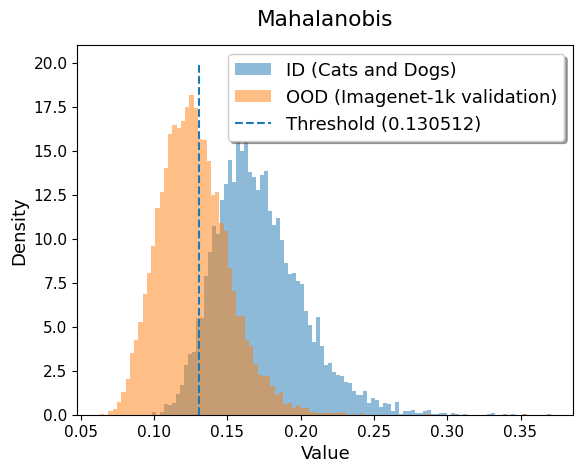

In [31]:
import matplotlib
visualizeThreshold(turmoil_switch(tl_cd_mahalanobis_distances), turmoil_switch(tl_s1ood_mahalanobis_distances), tl_cd_maha_threshold, title="Mahalanobis", extra_plot=False)

### Roadmap for performance measures.
For tl resnet and new resnet, for each setup, for each method. Create ID, OOD plot and ID, NearOOD, FarOOD plot.

Tab: setup,method,auroc,auprin,auprout,fpr95,threshold


Ensure, for mahalanobis, use turmoil_switch

In [35]:
from helpers import thresholdize, thresholdize_freq, get_measures

# ODIN
tl_s1_odin_auroc, tl_s1_odin_aupr_in, tl_s1_odin_aupr_out, tl_s1_odin_fpr95, tl_s1_odin_threshold = get_measures(turmoil(odin_s12_tl_in_examples), turmoil(odin_s1_tl_out_examples))
tl_s2_odin_auroc, tl_s2_odin_aupr_in, tl_s2_odin_aupr_out, tl_s2_odin_fpr95, tl_s2_odin_threshold = get_measures(turmoil(odin_s12_tl_in_examples), turmoil(odin_s2_tl_out_examples))
new_s1_odin_auroc, new_s1_odin_aupr_in, new_s1_odin_aupr_out, new_s1_odin_fpr95, new_s1_odin_threshold = get_measures(turmoil(odin_s12_new_in_examples), turmoil(odin_s1_new_out_examples))
new_s2_odin_auroc, new_s2_odin_aupr_in, new_s2_odin_aupr_out, new_s2_odin_fpr95, new_s2_odin_threshold = get_measures(turmoil(odin_s12_new_in_examples), turmoil(odin_s2_new_out_examples))

# Energy
tl_s1_energy_auroc, tl_s1_energy_aupr_in, tl_s1_energy_aupr_out, tl_s1_energy_fpr95, tl_s1_energy_threshold = get_measures(turmoil(energy_s12_tl_in_examples), turmoil(energy_s1_tl_out_examples))
tl_s2_energy_auroc, tl_s2_energy_aupr_in, tl_s2_energy_aupr_out, tl_s2_energy_fpr95, tl_s2_energy_threshold = get_measures(turmoil(energy_s12_tl_in_examples), turmoil(energy_s2_tl_out_examples))
new_s1_energy_auroc, new_s1_energy_aupr_in, new_s1_energy_aupr_out, new_s1_energy_fpr95, new_s1_energy_threshold = get_measures(turmoil(energy_s12_new_in_examples), turmoil(energy_s1_new_out_examples))
new_s2_energy_auroc, new_s2_energy_aupr_in, new_s2_energy_aupr_out, new_s2_energy_fpr95, new_s2_energy_threshold = get_measures(turmoil(energy_s12_new_in_examples), turmoil(energy_s2_new_out_examples))

# MSP
tl_s1_msp_auroc, tl_s1_msp_aupr_in, tl_s1_msp_aupr_out, tl_s1_msp_fpr95, tl_s1_msp_threshold = get_measures(turmoil(msp_s12_tl_in_examples), turmoil(msp_s1_tl_out_examples))
tl_s2_msp_auroc, tl_s2_msp_aupr_in, tl_s2_msp_aupr_out, tl_s2_msp_fpr95, tl_s2_msp_threshold = get_measures(turmoil(msp_s12_tl_in_examples), turmoil(msp_s2_tl_out_examples))
new_s1_msp_auroc, new_s1_msp_aupr_in, new_s1_msp_aupr_out, new_s1_msp_fpr95, new_s1_msp_threshold = get_measures(turmoil(msp_s12_new_in_examples), turmoil(msp_s1_new_out_examples))
new_s2_msp_auroc, new_s2_msp_aupr_in, new_s2_msp_aupr_out, new_s2_msp_fpr95, new_s2_msp_threshold = get_measures(turmoil(msp_s12_new_in_examples), turmoil(msp_s2_new_out_examples))

# DDU
tl_s1_ddu_auroc, tl_s1_ddu_aupr_in, tl_s1_ddu_aupr_out, tl_s1_ddu_fpr95, tl_s1_ddu_threshold = get_measures(turmoil(s12_tl_ddu_in_scores), turmoil(s1_tl_ddu_out_scores))
tl_s2_ddu_auroc, tl_s2_ddu_aupr_in, tl_s2_ddu_aupr_out, tl_s2_ddu_fpr95, tl_s2_ddu_threshold = get_measures(turmoil(s12_tl_ddu_in_scores), turmoil(s2_tl_ddu_out_scores))
new_s1_ddu_auroc, new_s1_ddu_aupr_in, new_s1_ddu_aupr_out, new_s1_ddu_fpr95, new_s1_ddu_threshold = get_measures(turmoil(s12_new_ddu_in_scores), turmoil(s1_new_ddu_out_scores))
new_s2_ddu_auroc, new_s2_ddu_aupr_in, new_s2_ddu_aupr_out, new_s2_ddu_fpr95, new_s2_ddu_threshold = get_measures(turmoil(s12_new_ddu_in_scores), turmoil(s2_new_ddu_out_scores))

# Mahalanobis
tl_s1_maha_auroc, tl_s1_maha_aupr_in, tl_s1_maha_aupr_out, tl_s1_maha_fpr95, tl_s1_maha_threshold = get_measures(turmoil_switch(tl_cd_mahalanobis_distances), turmoil_switch(tl_s1ood_mahalanobis_distances))
tl_s2_maha_auroc, tl_s2_maha_aupr_in, tl_s2_maha_aupr_out, tl_s2_maha_fpr95, tl_s2_maha_threshold = get_measures(turmoil_switch(tl_cd_mahalanobis_distances), turmoil_switch(tl_s2ood_mahalanobis_distances))
new_s1_maha_auroc, new_s1_maha_aupr_in, new_s1_maha_aupr_out, new_s1_maha_fpr95, new_s1_maha_threshold = get_measures(turmoil_switch(new_cd_mahalanobis_distances), turmoil_switch(new_s1ood_mahalanobis_distances))
new_s2_maha_auroc, new_s2_maha_aupr_in, new_s2_maha_aupr_out, new_s2_maha_fpr95, new_s2_maha_threshold = get_measures(turmoil_switch(new_cd_mahalanobis_distances), turmoil_switch(new_s2ood_mahalanobis_distances))

# s3
tl_s3_odin_auroc, tl_s3_odin_aupr_in, tl_s3_odin_aupr_out, tl_s3_odin_fpr95, tl_s3_odin_threshold = get_measures(turmoil(odin_s3_tl_in_examples), turmoil(odin_s3_tl_out_examples))
tl_s3_energy_auroc, tl_s3_energy_aupr_in, tl_s3_energy_aupr_out, tl_s3_energy_fpr95, tl_s3_energy_threshold = get_measures(turmoil(energy_s3_tl_in_examples), turmoil(energy_s3_tl_out_examples))
tl_s3_msp_auroc, tl_s3_msp_aupr_in, tl_s3_msp_aupr_out, tl_s3_msp_fpr95, tl_s3_msp_threshold = get_measures(turmoil(msp_s3_tl_in_examples), turmoil(msp_s3_tl_out_examples))
tl_s3_ddu_auroc, tl_s3_ddu_aupr_in, tl_s3_ddu_aupr_out, tl_s3_ddu_fpr95, tl_s3_ddu_threshold = get_measures(turmoil(s3_tl_ddu_in_scores), turmoil(s3_tl_ddu_out_scores))
tl_s3_maha_auroc, tl_s3_maha_aupr_in, tl_s3_maha_aupr_out, tl_s3_maha_fpr95, tl_s3_maha_threshold = get_measures(turmoil_switch(tl_cf_mahalanobis_distances), turmoil_switch(tl_s3ood_mahalanobis_distances))
new_s3_odin_auroc, new_s3_odin_aupr_in, new_s3_odin_aupr_out, new_s3_odin_fpr95, new_s3_odin_threshold = get_measures(turmoil(odin_s3_new_in_examples), turmoil(odin_s3_new_out_examples))
new_s3_energy_auroc, new_s3_energy_aupr_in, new_s3_energy_aupr_out, new_s3_energy_fpr95, new_s3_energy_threshold = get_measures(turmoil(energy_s3_new_in_examples), turmoil(energy_s3_new_out_examples))
new_s3_msp_auroc, new_s3_msp_aupr_in, new_s3_msp_aupr_out, new_s3_msp_fpr95, new_s3_msp_threshold = get_measures(turmoil(msp_s3_new_in_examples), turmoil(msp_s3_new_out_examples))
new_s3_ddu_auroc, new_s3_ddu_aupr_in, new_s3_ddu_aupr_out, new_s3_ddu_fpr95, new_s3_ddu_threshold = get_measures(turmoil(s3_new_ddu_in_scores), turmoil(s3_new_ddu_out_scores))
new_s3_maha_auroc, new_s3_maha_aupr_in, new_s3_maha_aupr_out, new_s3_maha_fpr95, new_s3_maha_threshold = get_measures(turmoil_switch(new_cf_mahalanobis_distances), turmoil_switch(new_s3ood_mahalanobis_distances))


In [37]:
print("Odin")
print("tl_s1", round(tl_s1_odin_auroc, 4), round(tl_s1_odin_aupr_in, 4), round(tl_s1_odin_aupr_out, 4), round(tl_s1_odin_fpr95, 4), round(tl_s1_odin_threshold, 4))
print("new_s1", round(new_s1_odin_auroc, 4), round(new_s1_odin_aupr_in, 4), round(new_s1_odin_aupr_out, 4), round(new_s1_odin_fpr95, 4), round(new_s1_odin_threshold, 4))
print("tl_s2", round(tl_s2_odin_auroc, 4), round(tl_s2_odin_aupr_in, 4), round(tl_s2_odin_aupr_out, 4), round(tl_s2_odin_fpr95, 4), round(tl_s2_odin_threshold, 4))
print("new_s2", round(new_s2_odin_auroc, 4), round(new_s2_odin_aupr_in, 4), round(new_s2_odin_aupr_out, 4), round(new_s2_odin_fpr95, 4), round(new_s2_odin_threshold, 4))
print("")
print("Energy")
print("tl_s1", round(tl_s1_energy_auroc, 4), round(tl_s1_energy_aupr_in, 4), round(tl_s1_energy_aupr_out, 4), round(tl_s1_energy_fpr95, 4), round(tl_s1_energy_threshold, 4))
print("new_s1", round(new_s1_energy_auroc, 4), round(new_s1_energy_aupr_in, 4), round(new_s1_energy_aupr_out, 4), round(new_s1_energy_fpr95, 4), round(new_s1_energy_threshold, 4))
print("tl_s2", round(tl_s2_energy_auroc, 4), round(tl_s2_energy_aupr_in, 4), round(tl_s2_energy_aupr_out, 4), round(tl_s2_energy_fpr95, 4), round(tl_s2_energy_threshold, 4))
print("new_s2", round(new_s2_energy_auroc, 4), round(new_s2_energy_aupr_in, 4), round(new_s2_energy_aupr_out, 4), round(new_s2_energy_fpr95, 4), round(new_s2_energy_threshold, 4))
print("")
print("MSP")
print("tl_s1", round(tl_s1_msp_auroc, 4), round(tl_s1_msp_aupr_in, 4), round(tl_s1_msp_aupr_out, 4), round(tl_s1_msp_fpr95, 4), round(tl_s1_msp_threshold, 4))
print("new_s1", round(new_s1_msp_auroc, 4), round(new_s1_msp_aupr_in, 4), round(new_s1_msp_aupr_out, 4), round(new_s1_msp_fpr95, 4), round(new_s1_msp_threshold, 4))
print("tl_s2", round(tl_s2_msp_auroc, 4), round(tl_s2_msp_aupr_in, 4), round(tl_s2_msp_aupr_out, 4), round(tl_s2_msp_fpr95, 4), round(tl_s2_msp_threshold, 4))
print("new_s2", round(new_s2_msp_auroc, 4), round(new_s2_msp_aupr_in, 4), round(new_s2_msp_aupr_out, 4), round(new_s2_msp_fpr95, 4), round(new_s2_msp_threshold, 4))
print("")
print("DDU")
print("tl_s1", round(tl_s1_ddu_auroc, 4), round(tl_s1_ddu_aupr_in, 4), round(tl_s1_ddu_aupr_out, 4), round(tl_s1_ddu_fpr95, 4), round(tl_s1_ddu_threshold, 4))
print("new_s1", round(new_s1_ddu_auroc, 4), round(new_s1_ddu_aupr_in, 4), round(new_s1_ddu_aupr_out, 4), round(new_s1_ddu_fpr95, 4), round(new_s1_ddu_threshold, 4))
print("tl_s2", round(tl_s2_ddu_auroc, 4), round(tl_s2_ddu_aupr_in, 4), round(tl_s2_ddu_aupr_out, 4), round(tl_s2_ddu_fpr95, 4), round(tl_s2_ddu_threshold, 4))
print("new_s2", round(new_s2_ddu_auroc, 4), round(new_s2_ddu_aupr_in, 4), round(new_s2_ddu_aupr_out, 4), round(new_s2_ddu_fpr95, 4), round(new_s2_ddu_threshold, 4))
print("")
print("Mahalanobis")
print("tl_s1", round(tl_s1_maha_auroc, 4), round(tl_s1_maha_aupr_in, 4), round(tl_s1_maha_aupr_out, 4), round(tl_s1_maha_fpr95, 4), round(tl_s1_maha_threshold, 4))
print("new_s1", round(new_s1_maha_auroc, 4), round(new_s1_maha_aupr_in, 4), round(new_s1_maha_aupr_out, 4), round(new_s1_maha_fpr95, 4), round(new_s1_maha_threshold, 4))
print("tl_s2", round(tl_s2_maha_auroc, 4), round(tl_s2_maha_aupr_in, 4), round(tl_s2_maha_aupr_out, 4), round(tl_s2_maha_fpr95, 4), round(tl_s2_maha_threshold, 4))
print("new_s2", round(new_s2_maha_auroc, 4), round(new_s2_maha_aupr_in, 4), round(new_s2_maha_aupr_out, 4), round(new_s2_maha_fpr95, 4), round(new_s2_maha_threshold, 4))

print("")
print("s3")
print("tl_s3 odin", round(tl_s3_odin_auroc, 4), round(tl_s3_odin_aupr_in, 4), round(tl_s3_odin_aupr_out, 4), round(tl_s3_odin_fpr95, 4), round(tl_s3_odin_threshold, 4))
print("tl_s3 energy", round(tl_s3_energy_auroc, 4), round(tl_s3_energy_aupr_in, 4), round(tl_s3_energy_aupr_out, 4), round(tl_s3_energy_fpr95, 4), round(tl_s3_energy_threshold, 4))
print("tl_s3 msp", round(tl_s3_msp_auroc, 4), round(tl_s3_msp_aupr_in, 4), round(tl_s3_msp_aupr_out, 4), round(tl_s3_msp_fpr95, 4), round(tl_s3_msp_threshold, 4))
print("tl_s3 ddu", round(tl_s3_ddu_auroc, 4), round(tl_s3_ddu_aupr_in, 4), round(tl_s3_ddu_aupr_out, 4), round(tl_s3_ddu_fpr95, 4), round(tl_s3_ddu_threshold, 4))
print("tl_s3 maha", round(tl_s3_maha_auroc, 4), round(tl_s3_maha_aupr_in, 4), round(tl_s3_maha_aupr_out, 4), round(tl_s3_maha_fpr95, 4), round(tl_s3_maha_threshold, 4))
print("new_s3 odin", round(new_s3_odin_auroc, 4), round(new_s3_odin_aupr_in, 4), round(new_s3_odin_aupr_out, 4), round(new_s3_odin_fpr95, 4), round(new_s3_odin_threshold, 4))
print("new_s3 energy", round(new_s3_energy_auroc, 4), round(new_s3_energy_aupr_in, 4), round(new_s3_energy_aupr_out, 4), round(new_s3_energy_fpr95, 4), round(new_s3_energy_threshold, 4))
print("new_s3 msp", round(new_s3_msp_auroc, 4), round(new_s3_msp_aupr_in, 4), round(new_s3_msp_aupr_out, 4), round(new_s3_msp_fpr95, 4), round(new_s3_msp_threshold, 4))
print("new_s3 ddu", round(new_s3_ddu_auroc, 4), round(new_s3_ddu_aupr_in, 4), round(new_s3_ddu_aupr_out, 4), round(new_s3_ddu_fpr95, 4), round(new_s3_ddu_threshold, 4))
print("new_s3 maha", round(new_s3_maha_auroc, 4), round(new_s3_maha_aupr_in, 4), round(new_s3_maha_aupr_out, 4), round(new_s3_maha_fpr95, 4), round(new_s3_maha_threshold, 4))



Odin
tl_s1 0.9421 0.9402 0.9221 0.3006 0.0273
new_s1 0.7774 0.7753 0.7448 0.8961 0.0272
tl_s2 0.905 0.9207 0.8706 0.4424 0.0273
new_s2 0.719 0.7685 0.5972 0.9136 0.0272

Energy
tl_s1 0.9416 0.9462 0.9144 0.3798 5.0757
new_s1 0.762 0.7633 0.7215 0.9457 4.9931
tl_s2 0.9113 0.9322 0.8551 0.4711 5.0761
new_s2 0.7053 0.7599 0.5704 0.9588 4.9931

MSP
tl_s1 0.9153 0.9143 0.8973 0.4792 0.2832
new_s1 0.7735 0.7735 0.744 0.8958 0.2635
tl_s2 0.8894 0.9145 0.8361 0.5125 0.2832
new_s2 0.7426 0.8004 0.6142 0.9114 0.2637

DDU
tl_s1 0.739 0.6875 0.7826 0.7437 -67.1824
new_s1 0.7454 0.6613 0.7982 0.7081 -94.1419
tl_s2 0.7036 0.7097 0.7013 0.6912 -67.1866
new_s2 0.8183 0.819 0.808 0.5632 -94.1394

Mahalanobis
tl_s1 0.8912 0.8512 0.9194 0.4112 0.1305
new_s1 0.8048 0.7073 0.8624 0.5437 0.1295
tl_s2 0.8461 0.8244 0.8531 0.4424 0.1305
new_s2 0.8689 0.8551 0.876 0.3884 0.1295

s3
tl_s3 odin 0.9648 0.9147 0.9885 0.2069 0.01
tl_s3 energy 0.95 0.8861 0.9827 0.3076 7.9661
tl_s3 msp 0.9237 0.8384 0.973 0.5107 0.3

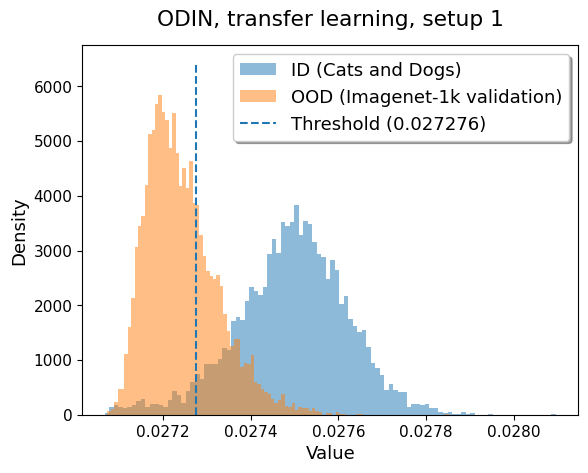

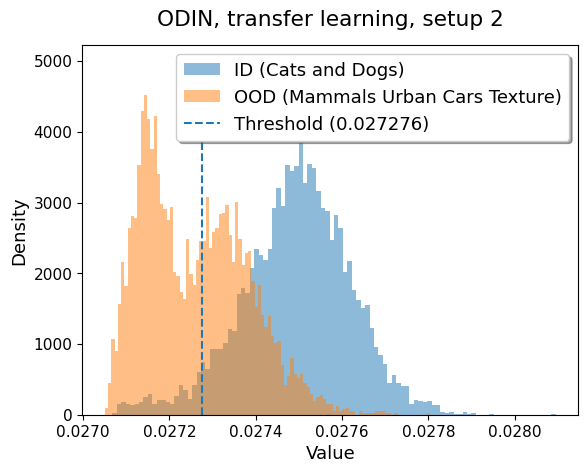

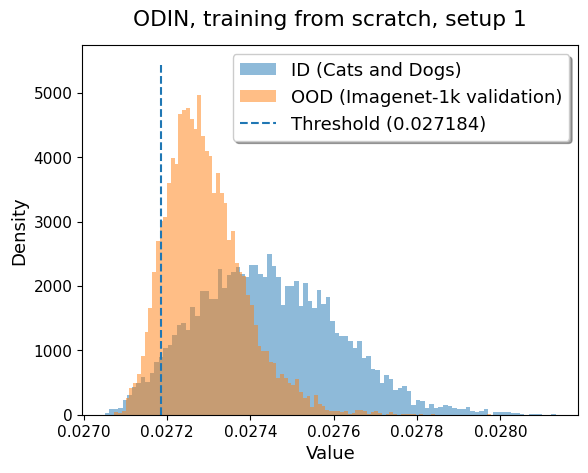

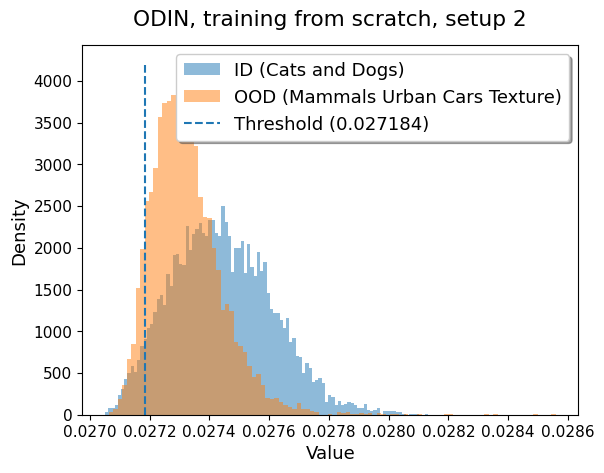

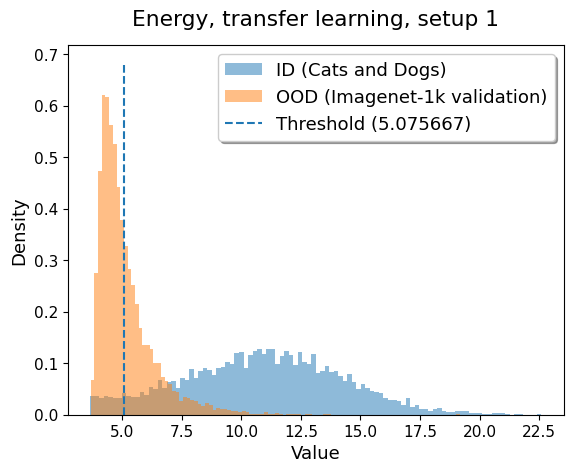

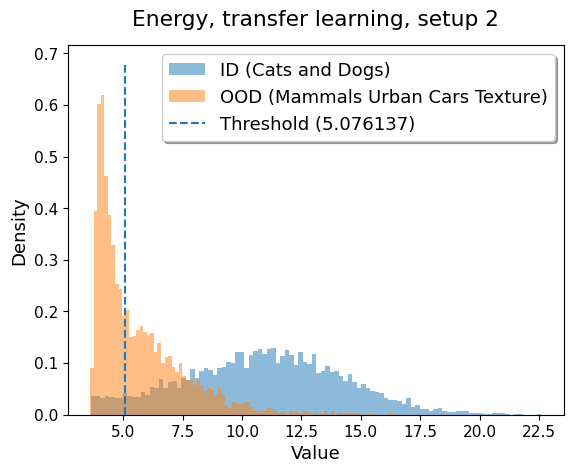

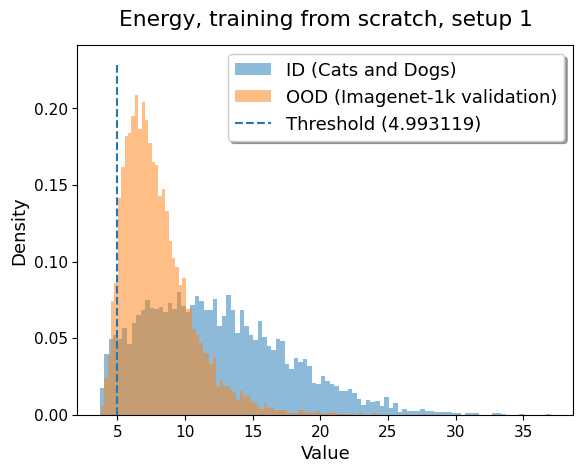

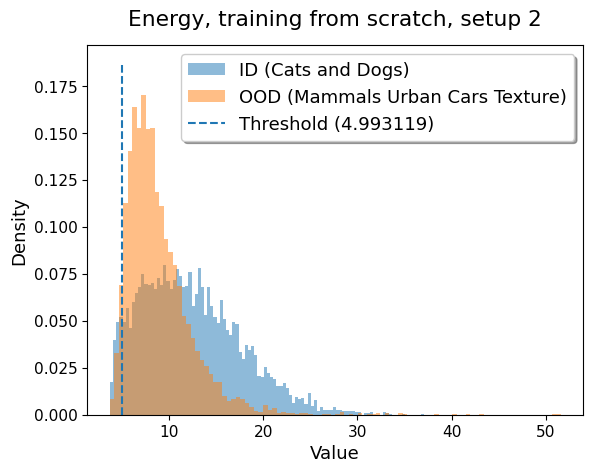

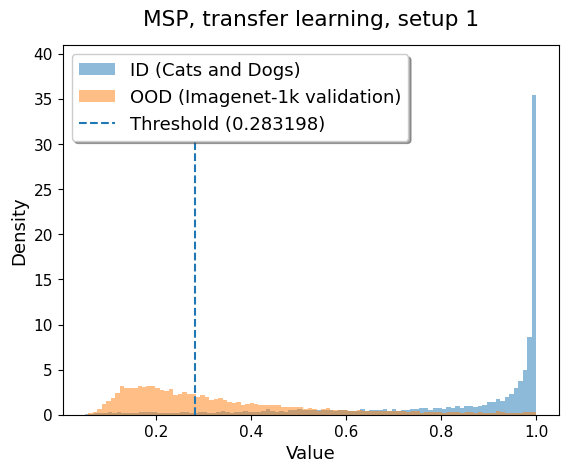

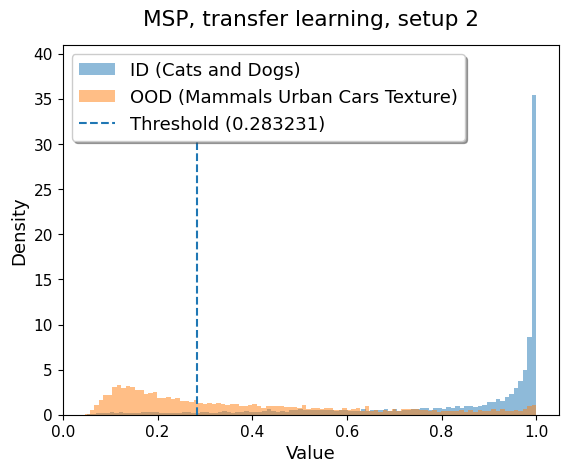

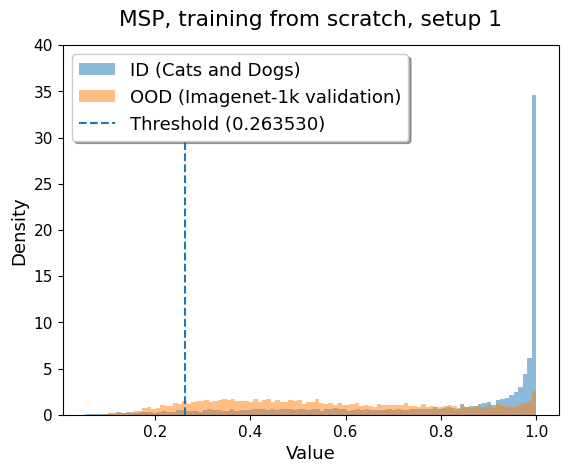

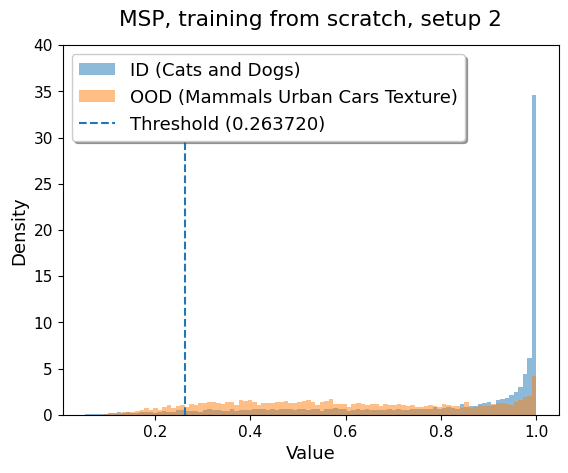

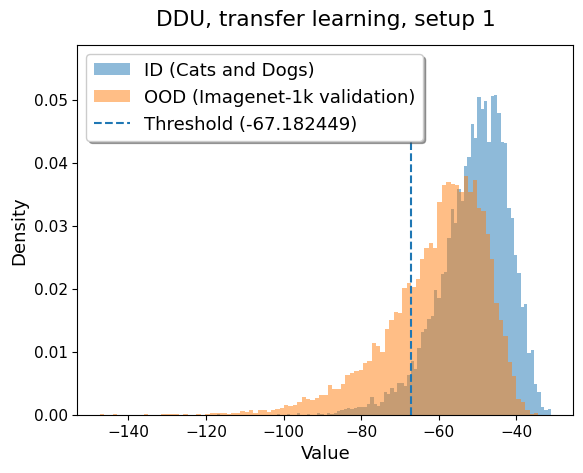

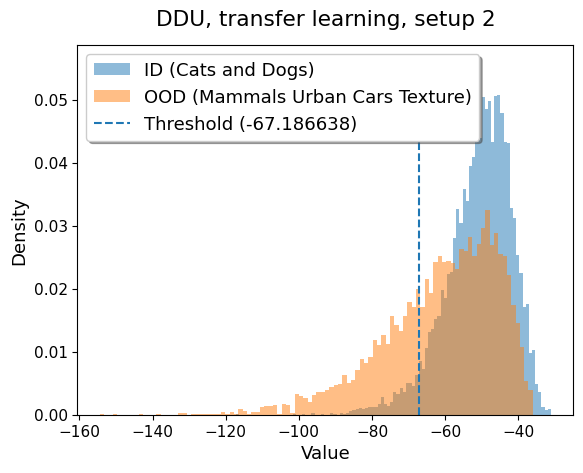

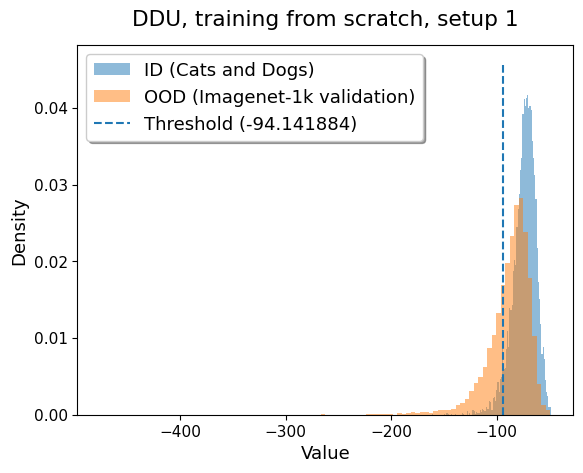

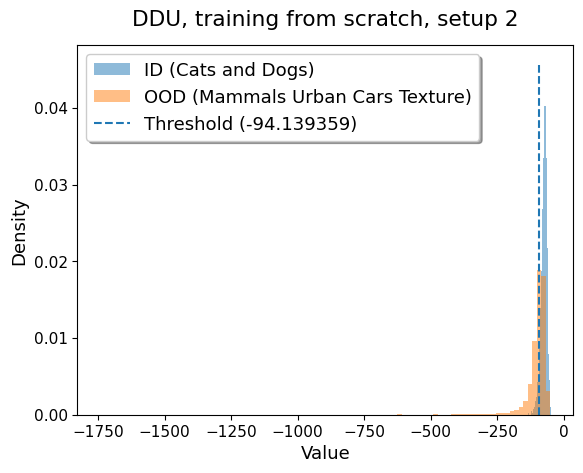

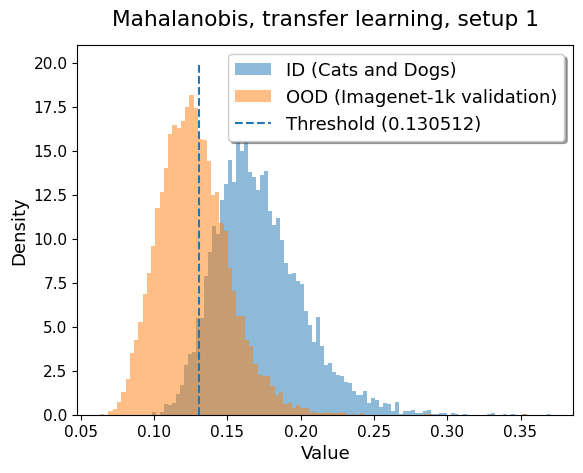

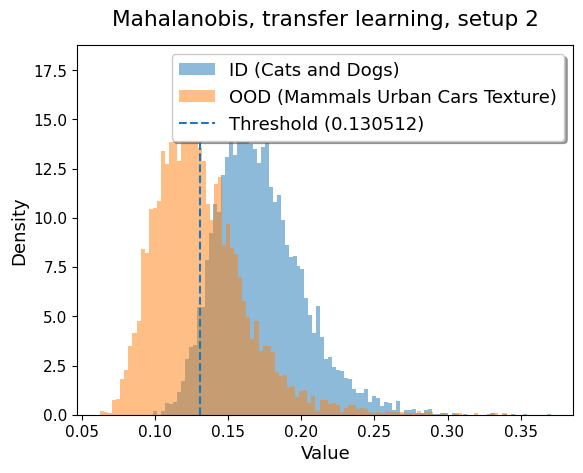

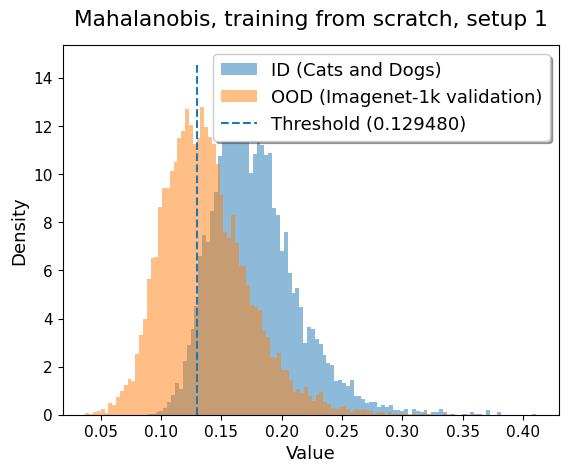

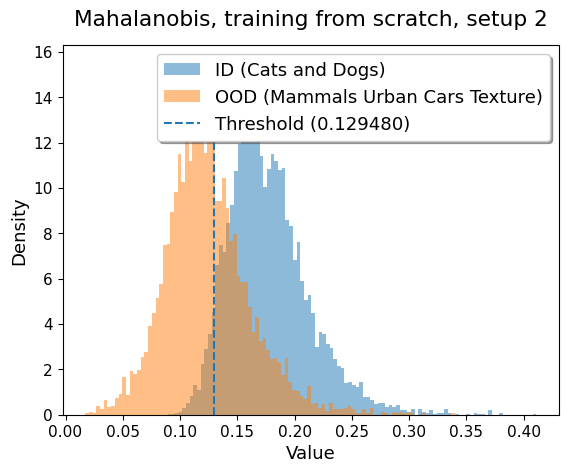

In [29]:
# ODIN
visualizeThreshold(turmoil(odin_s12_tl_in_examples), turmoil(odin_s1_tl_out_examples), tl_s1_odin_threshold, "ODIN, transfer learning, setup 1", extra_plot=False)
visualizeThreshold(turmoil(odin_s12_tl_in_examples), turmoil(odin_s2_tl_out_examples), tl_s2_odin_threshold, "ODIN, transfer learning, setup 2", l2='OOD (Mammals Urban Cars Texture)', extra_plot=False)
visualizeThreshold(turmoil(odin_s12_new_in_examples), turmoil(odin_s1_new_out_examples), new_s1_odin_threshold, "ODIN, training from scratch, setup 1", extra_plot=False)
visualizeThreshold(turmoil(odin_s12_new_in_examples), turmoil(odin_s2_new_out_examples), new_s2_odin_threshold, "ODIN, training from scratch, setup 2", l2='OOD (Mammals Urban Cars Texture)', extra_plot=False)

# Energy
visualizeThreshold(turmoil(energy_s12_tl_in_examples), turmoil(energy_s1_tl_out_examples), tl_s1_energy_threshold, "Energy, transfer learning, setup 1", extra_plot=False)
visualizeThreshold(turmoil(energy_s12_tl_in_examples), turmoil(energy_s2_tl_out_examples), tl_s2_energy_threshold, "Energy, transfer learning, setup 2", l2='OOD (Mammals Urban Cars Texture)', extra_plot=False)
visualizeThreshold(turmoil(energy_s12_new_in_examples), turmoil(energy_s1_new_out_examples), new_s1_energy_threshold, "Energy, training from scratch, setup 1", extra_plot=False)
visualizeThreshold(turmoil(energy_s12_new_in_examples), turmoil(energy_s2_new_out_examples), new_s2_energy_threshold, "Energy, training from scratch, setup 2", l2='OOD (Mammals Urban Cars Texture)', extra_plot=False)

# MSP
visualizeThreshold(turmoil(msp_s12_tl_in_examples), turmoil(msp_s1_tl_out_examples), tl_s1_msp_threshold, "MSP, transfer learning, setup 1", extra_plot=False)
visualizeThreshold(turmoil(msp_s12_tl_in_examples), turmoil(msp_s2_tl_out_examples), tl_s2_msp_threshold, "MSP, transfer learning, setup 2", l2='OOD (Mammals Urban Cars Texture)', extra_plot=False)
visualizeThreshold(turmoil(msp_s12_new_in_examples), turmoil(msp_s1_new_out_examples), new_s1_msp_threshold, "MSP, training from scratch, setup 1", extra_plot=False)
visualizeThreshold(turmoil(msp_s12_new_in_examples), turmoil(msp_s2_new_out_examples), new_s2_msp_threshold, "MSP, training from scratch, setup 2", l2='OOD (Mammals Urban Cars Texture)', extra_plot=False)

# DDU
visualizeThreshold(turmoil(s12_tl_ddu_in_scores), turmoil(s1_tl_ddu_out_scores), tl_s1_ddu_threshold, "DDU, transfer learning, setup 1", extra_plot=False)
visualizeThreshold(turmoil(s12_tl_ddu_in_scores), turmoil(s2_tl_ddu_out_scores), tl_s2_ddu_threshold, "DDU, transfer learning, setup 2", l2='OOD (Mammals Urban Cars Texture)', extra_plot=False)
visualizeThreshold(turmoil(s12_new_ddu_in_scores), turmoil(s1_new_ddu_out_scores), new_s1_ddu_threshold, "DDU, training from scratch, setup 1", extra_plot=False)
visualizeThreshold(turmoil(s12_new_ddu_in_scores), turmoil(s2_new_ddu_out_scores), new_s2_ddu_threshold, "DDU, training from scratch, setup 2", l2='OOD (Mammals Urban Cars Texture)', extra_plot=False)

# Mahalanobis
visualizeThreshold(turmoil_switch(tl_cd_mahalanobis_distances), turmoil_switch(tl_s1ood_mahalanobis_distances), tl_s1_maha_threshold, "Mahalanobis, transfer learning, setup 1", extra_plot=False)
visualizeThreshold(turmoil_switch(tl_cd_mahalanobis_distances), turmoil_switch(tl_s2ood_mahalanobis_distances), tl_s2_maha_threshold, "Mahalanobis, transfer learning, setup 2", l2='OOD (Mammals Urban Cars Texture)', extra_plot=False)
visualizeThreshold(turmoil_switch(new_cd_mahalanobis_distances), turmoil_switch(new_s1ood_mahalanobis_distances), new_s1_maha_threshold, "Mahalanobis, training from scratch, setup 1", extra_plot=False)
visualizeThreshold(turmoil_switch(new_cd_mahalanobis_distances), turmoil_switch(new_s2ood_mahalanobis_distances), new_s2_maha_threshold, "Mahalanobis, training from scratch, setup 2", l2='OOD (Mammals Urban Cars Texture)', extra_plot=False)

### Get loss and accuracies to create plots

In [30]:
from tqdm import tqdm
# For a list of network weights:
#  return list of losses, list of training accuracies and list of validation accuracies

def get_loss_accs(file_name_list):
    loss_list = list()
    trainacc_list = list()
    valacc_list = list()

    for file_name in tqdm(file_name_list):
        # Load model. Where we transfer learned resnet18 from Imagenet1k weights to cats and dogs
        from torchvision.models import resnet18, ResNet18_Weights
        
        pretrained_resnet = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
        
        # Unlock layers
        for param in pretrained_resnet.parameters():
            param.requires_grad = True
        
        # Modify the output layer to 37
        num_classes = len(class_dict.items())
        pretrained_resnet.fc = nn.Linear(pretrained_resnet.fc.in_features, num_classes)
        
        # Define loss function and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.SGD(pretrained_resnet.parameters(), lr=0.001, momentum=0.9)
        
        # Load pre-trained weights
        pretrained_resnet.load_state_dict(torch.load(file_name))
        pretrained_resnet.eval()
        
        pretrained_resnet.train()
    
        correct = 0
        total = 0
        epoch_loss = list()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
        
            outputs = pretrained_resnet(inputs)
            loss = criterion(outputs, labels)
            epoch_loss.append(loss.item())
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
        loss_list.append(sum(epoch_loss)/len(epoch_loss))
        trainacc_list.append(100 * correct / total)
        
        correct = 0
        total = 0
        pretrained_resnet.eval()
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = pretrained_resnet(inputs)
                # Update validation metrics if needed
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        valacc_list.append(100 * correct / total)

    return loss_list, trainacc_list, valacc_list


In [31]:
new_res_file_list = ["catsDogs_new_resnet_0.pth", "catsDogs_new_resnet_5.pth", "catsDogs_new_resnet_10.pth", "catsDogs_new_resnet_25.pth", "catsDogs_new_resnet_50.pth", "catsDogs_new_resnet_75.pth", "catsDogs_new_resnet_125.pth", "catsDogs_new_resnet_150.pth", "catsDogs_new_resnet_175.pth", "catsDogs_new_resnet_200.pth", "catsDogs_new_resnet_250.pth", "catsDogs_new_resnet_275.pth", "catsDogs_new_resnet_300.pth"]
res_file_list = ["catsDogs_resnet_0.pth", "catsDogs_resnet_5.pth", "catsDogs_resnet_25.pth", "catsDogs_resnet_50.pth", "catsDogs_resnet_75.pth", "catsDogs_resnet_100.pth"]

new_loss_list, new_trainacc_list, new_valacc_list = get_loss_accs(new_res_file_list)
tl_loss_list, tl_trainacc_list, tl_valacc_list = get_loss_accs(res_file_list)

100%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [15:45<00:00, 157.65s/it]


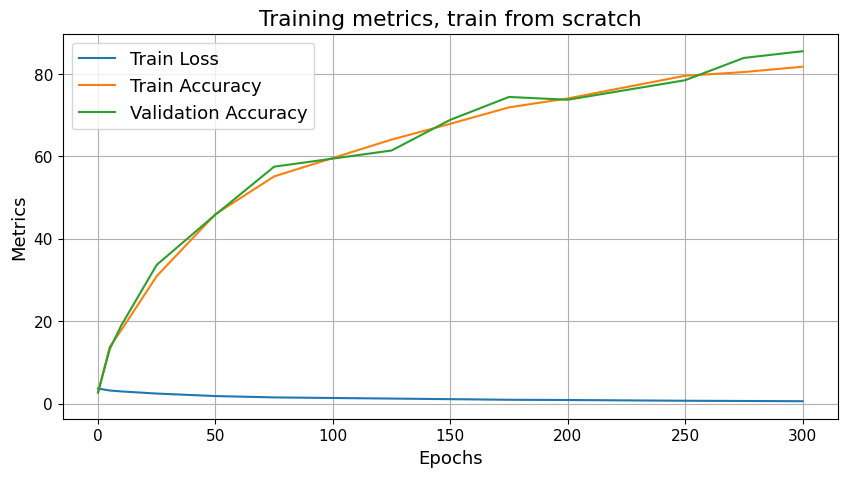

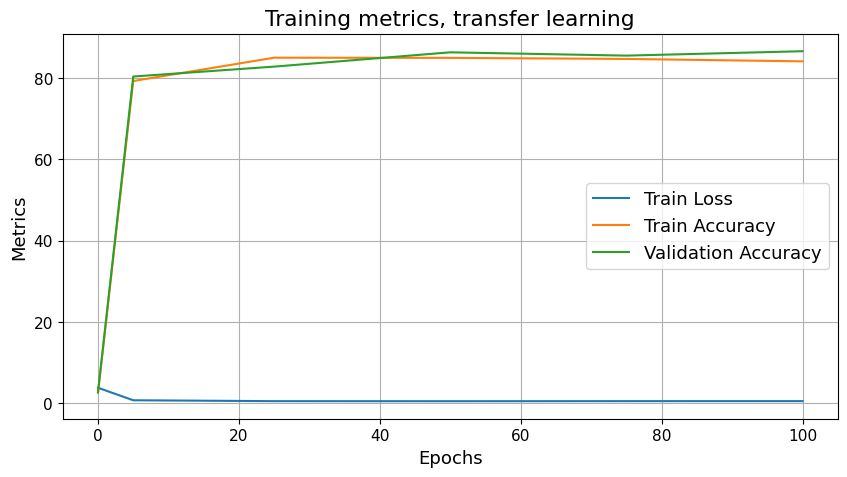

In [34]:
new_epochs = [0, 5, 10, 25, 50, 75, 125, 150, 175, 200, 250, 275, 300]
tl_epochs = [0, 5, 25, 50, 75, 100]

def vis_loss_acc(epochs_list, loss_list, trainacc_list, valacc_list, title):
    plt.figure(figsize=(10, 5))
    plt.plot(epochs_list, loss_list, label='Train Loss')
    plt.plot(epochs_list, trainacc_list, label='Train Accuracy')
    plt.plot(epochs_list, valacc_list, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Metrics')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

vis_loss_acc(new_epochs, new_loss_list, new_trainacc_list, new_valacc_list, "Training metrics, train from scratch")
vis_loss_acc(tl_epochs, tl_loss_list, tl_trainacc_list, tl_valacc_list, "Training metrics, transfer learning")


In [35]:
np.save('exp1saves/new_loss_list.npy', new_loss_list)
np.save('exp1saves/new_trainacc_list.npy', new_trainacc_list)
np.save('exp1saves/new_valacc_list.npy', new_valacc_list)
np.save('exp1saves/tl_loss_list.npy', tl_loss_list)
np.save('exp1saves/tl_trainacc_list.npy', tl_trainacc_list)
np.save('exp1saves/tl_valacc_list.npy', tl_valacc_list)

# new_loss_list = np.load('exp1saves/new_loss_list.npy')
# new_trainacc_list = np.load('exp1saves/new_trainacc_list.npy')
# new_valacc_list = np.load('exp1saves/new_valacc_list.npy')
# tl_loss_list = np.load('exp1saves/tl_loss_list.npy')
# tl_trainacc_list = np.load('exp1saves/tl_trainacc_list.npy')
# tl_valacc_list = np.load('exp1saves/tl_valacc_list.npy')


In [39]:
print(new_loss_list)
print(new_trainacc_list)
print(new_valacc_list)
print("")
print(tl_loss_list)
print(tl_trainacc_list)
print(tl_valacc_list)

[3.6835532658375225, 3.2037595017598224, 2.9824286011549144, 2.4676755563570905, 1.859782898082183, 1.5342326161379998, 1.2528864322946622, 1.108726484557757, 0.9611919523718265, 0.9045171482631793, 0.7225648184808401, 0.6682108849860154, 0.6088194336312321]
[2.721395278905428, 13.802435723951286, 17.937152307923622, 30.95775071417832, 45.99308374680499, 55.149601563674636, 64.08058938505488, 67.91459930837468, 71.89896256202074, 74.06405051871899, 79.56698240866035, 80.46910239061795, 81.76214103142385]
[2.706359945872801, 13.261163734776725, 19.079837618403246, 33.69418132611637, 45.87280108254398, 57.51014884979702, 61.43437077131259, 68.87686062246279, 74.42489851150204, 73.74830852503383, 78.48443843031123, 83.89715832205684, 85.52097428958051]

[3.8015570652026396, 0.7261969677817363, 0.5054008361811821, 0.4896022558498841, 0.5081395695272547, 0.5145702182960051]
[2.6011126146444146, 79.26627574800781, 85.0097729664712, 84.96466696737333, 84.70906630581868, 84.1076529845136]
[2.7